# HoneyBee Workshop Part 4: Multimodal Data Integration and t-SNE Visualization

This notebook demonstrates how to load multimodal TCGA data from HuggingFace and create comprehensive t-SNE visualizations for individual modalities and integrated multimodal representations.

## 1. Setup and Imports

Configure the environment and import necessary libraries for multimodal data processing and visualization.

In [29]:
# Add HoneyBee to path
import sys
from pathlib import Path

current_dir = Path.cwd()
project_root = current_dir.parent.parent  # Go up two levels from examples/mayo to project root
honeybee_path = str(project_root)
if honeybee_path not in sys.path:
    sys.path.insert(0, honeybee_path)

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# HuggingFace datasets
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ Imports successful")
print(f"  Working directory: {current_dir}")
print(f"  HoneyBee path: {honeybee_path}")

✓ Imports successful
  Working directory: /mnt/f/Projects/HoneyBee/examples/mayo
  HoneyBee path: /mnt/f/Projects/HoneyBee


## 2. Load TCGA Multimodal Dataset from HuggingFace

The Lab-Rasool/TCGA dataset contains pre-computed embeddings from multiple state-of-the-art models across different modalities:

### Available Modalities:
- **Clinical Data**: Patient demographics, treatment history, and clinical notes
- **Pathology Reports**: Diagnostic pathology text reports
- **WSI (Whole Slide Images)**: Digital pathology slide embeddings
- **Molecular Data**: Genomic and transcriptomic features
- **Radiology Images**: CT/MRI scan embeddings

### Available Models:
- **Clinical/Pathology**: GatorTron, MedGemma, Qwen, Llama
- **WSI**: UNI (Universal Medical Image Encoder)
- **Molecular**: SeNMo (Self-Normalizing Networks for Multi-Omics)
- **Radiology**: REMEDIS, RadImageNet

In [30]:
# Define a custom dataset class for handling buffer embeddings
class TCGAEmbeddingDataset(Dataset):
    """Custom dataset for TCGA embeddings stored as buffers"""
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        
        # Convert buffer to numpy array
        if 'embedding' in item and item['embedding'] is not None:
            embedding = np.frombuffer(item['embedding'], dtype=np.float32)
            if 'embedding_shape' in item:
                embedding = embedding.reshape(item['embedding_shape'])
        else:
            embedding = None
            
        return {
            'embedding': embedding,
            'metadata': {k: v for k, v in item.items() if k not in ['embedding', 'embedding_shape']}
        }

# Load different modalities - we'll use GatorTron for clinical/pathology as default
print("Loading TCGA multimodal dataset from HuggingFace...")

# Clinical embeddings
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
print(f"Clinical data loaded: {len(clinical_dataset)} samples")

# Pathology report embeddings  
pathology_dataset = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="gatortron")
print(f"Pathology data loaded: {len(pathology_dataset)} samples")

# WSI embeddings
try:
    wsi_dataset = load_dataset("Lab-Rasool/TCGA", "wsi", split="uni")
    print(f"WSI data loaded: {len(wsi_dataset)} samples")
except:
    print("WSI data not available")
    wsi_dataset = None

# Molecular embeddings
try:
    molecular_dataset = load_dataset("Lab-Rasool/TCGA", "molecular", split="senmo")
    print(f"Molecular data loaded: {len(molecular_dataset)} samples")
except:
    print("Molecular data not available")
    molecular_dataset = None

# Radiology embeddings
try:
    radiology_dataset = load_dataset("Lab-Rasool/TCGA", "radiology", split="radimagenet")
    print(f"Radiology data loaded: {len(radiology_dataset)} samples")
except:
    print("Radiology data not available")
    radiology_dataset = None

Loading TCGA multimodal dataset from HuggingFace...


Clinical data loaded: 10771 samples
Pathology data loaded: 10857 samples
WSI data loaded: 22643 samples
Molecular data loaded: 13804 samples
Radiology data loaded: 11870 samples


## 3. Data Extraction and Processing

Extract embeddings and metadata from the HuggingFace datasets, handling different data formats and structures.

In [31]:
def extract_embeddings_and_metadata(dataset, modality_name):
    """
    Extract embeddings and metadata from a HuggingFace dataset.
    Handles different embedding formats and shapes across modalities.
    """
    embeddings = []
    metadata = []
    
    # First, let's check what the data looks like
    if len(dataset) > 0:
        sample_item = dataset[0]
        print(f"\n📊 Checking {modality_name} data structure:")
        print(f"  Keys available: {list(sample_item.keys())[:10]}...")
        
        # Check for different embedding key names
        embedding_key = None
        if 'embedding' in sample_item:
            embedding_key = 'embedding'
        elif 'Embeddings' in sample_item:
            embedding_key = 'Embeddings'
        
        if embedding_key and sample_item[embedding_key] is not None:
            if isinstance(sample_item[embedding_key], bytes):
                emb = np.frombuffer(sample_item[embedding_key], dtype=np.float32)
            else:
                emb = np.array(sample_item[embedding_key], dtype=np.float32)
                
            if 'embedding_shape' in sample_item:
                original_shape = sample_item['embedding_shape']
                print(f"  Original embedding shape: {original_shape}")
                emb = emb.reshape(original_shape)
            print(f"  Sample embedding shape: {emb.shape}")
    
    # Process all items
    for i in range(len(dataset)):
        item = dataset[i]
        
        # Extract embedding - check different key names
        embedding = None
        embedding_key = None
        
        if 'embedding' in item and item['embedding'] is not None:
            embedding_key = 'embedding'
            if isinstance(item['embedding'], bytes):
                embedding = np.frombuffer(item['embedding'], dtype=np.float32)
            else:
                embedding = np.array(item['embedding'], dtype=np.float32)
                
            if 'embedding_shape' in item:
                embedding = embedding.reshape(item['embedding_shape'])
                
        elif 'Embeddings' in item and item['Embeddings'] is not None:
            embedding_key = 'Embeddings'
            embedding = np.array(item['Embeddings'], dtype=np.float32)
        
        if embedding is not None:
            # Handle different modalities specifically
            if modality_name == 'wsi' and len(embedding.shape) == 2:
                # For WSI, average over patches to get a single embedding per slide
                embedding = np.mean(embedding, axis=0)
                
            elif modality_name == 'radiology' and len(embedding.shape) == 2:
                # For radiology, squeeze the first dimension if it's 1
                if embedding.shape[0] == 1:
                    embedding = embedding.squeeze(0)
                else:
                    # Average over the first dimension
                    embedding = np.mean(embedding, axis=0)
                    
            elif modality_name == 'molecular':
                # Molecular might already be 1D
                if len(embedding.shape) > 1:
                    embedding = embedding.flatten()
                    
            elif len(embedding.shape) > 1:
                # For other cases, flatten
                embedding = embedding.flatten()
            
            # Only add if we have a reasonable size embedding
            if embedding.shape[0] < 100000:  # Avoid extremely large flattened embeddings
                embeddings.append(embedding)
                
                # Extract metadata
                meta = {k: v for k, v in item.items() if k not in [embedding_key, 'embedding_shape']}
                meta['modality'] = modality_name
                meta['original_shape'] = item.get('embedding_shape', embedding.shape)
                metadata.append(meta)
    
    # Convert to numpy array, handling potential shape mismatches
    if embeddings:
        # Check if all embeddings have the same shape
        shapes = [emb.shape for emb in embeddings]
        unique_shapes = list(set(shapes))
        
        if len(unique_shapes) == 1:
            embeddings = np.array(embeddings)
            print(f"  ✓ Final {modality_name} embeddings shape: {embeddings.shape}")
        else:
            # If shapes differ, pad to max dimension
            print(f"  ⚠️ Warning: {modality_name} has variable embedding dimensions.")
            print(f"  Unique shapes (showing first 5): {unique_shapes[:5]}")
            max_dim = max(emb.shape[0] for emb in embeddings)
            
            # Only pad if max dimension is reasonable
            if max_dim < 10000:
                padded_embeddings = []
                for emb in embeddings:
                    if emb.shape[0] < max_dim:
                        padded = np.pad(emb, (0, max_dim - emb.shape[0]), mode='constant')
                    else:
                        padded = emb[:max_dim]
                    padded_embeddings.append(padded)
                embeddings = np.array(padded_embeddings)
                print(f"  ✓ Final {modality_name} embeddings shape after padding: {embeddings.shape}")
            else:
                print(f"  ❌ Skipping {modality_name} due to very large dimensions")
                embeddings = None
    else:
        embeddings = None
        
    metadata_df = pd.DataFrame(metadata) if metadata else None
    
    return embeddings, metadata_df

# Extract embeddings for each modality
print("🔄 Extracting embeddings and metadata...")
print("=" * 60)

clinical_embeddings, clinical_metadata = extract_embeddings_and_metadata(clinical_dataset, 'clinical')
print(f"\n✅ Clinical embeddings: {clinical_embeddings.shape if clinical_embeddings is not None else 'None'}")

pathology_embeddings, pathology_metadata = extract_embeddings_and_metadata(pathology_dataset, 'pathology')
print(f"✅ Pathology embeddings: {pathology_embeddings.shape if pathology_embeddings is not None else 'None'}")

# For WSI, Molecular, and Radiology - check if available
wsi_embeddings, wsi_metadata = (None, None)
molecular_embeddings, molecular_metadata = (None, None)
radiology_embeddings, radiology_metadata = (None, None)

if wsi_dataset:
    wsi_embeddings, wsi_metadata = extract_embeddings_and_metadata(wsi_dataset, 'wsi')
    print(f"✅ WSI embeddings: {wsi_embeddings.shape if wsi_embeddings is not None else 'None'}")

if molecular_dataset:
    molecular_embeddings, molecular_metadata = extract_embeddings_and_metadata(molecular_dataset, 'molecular')
    print(f"✅ Molecular embeddings: {molecular_embeddings.shape if molecular_embeddings is not None else 'None'}")
    
if radiology_dataset:
    radiology_embeddings, radiology_metadata = extract_embeddings_and_metadata(radiology_dataset, 'radiology')
    print(f"✅ Radiology embeddings: {radiology_embeddings.shape if radiology_embeddings is not None else 'None'}")

print("\n" + "=" * 60)

🔄 Extracting embeddings and metadata...

📊 Checking clinical data structure:
  Keys available: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number']...
  Original embedding shape: [1024]
  Sample embedding shape: (1024,)
  ✓ Final clinical embeddings shape: (10771, 1024)

✅ Clinical embeddings: (10771, 1024)

📊 Checking pathology data structure:
  Keys available: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type']...
  Original embedding shape: [1024]
  Sample embedding shape: (1024,)
  ✓ Final pathology embeddings shape: (10857, 1024)
✅ Pathology embeddings: (10857, 1024)

📊 Checking wsi data structure:
  Keys available: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type']...
  Original embedding sha

## 3.5 Build Patient-Modality Mapping

To properly integrate multimodal data, we need to track which modalities are available for each patient. This mapping is crucial for:
- Identifying patients with multiple modalities
- Ensuring correct alignment across modalities
- Computing modality combination statistics

In [32]:
# Build comprehensive patient-modality mapping
print("🔍 Building patient-modality mapping...")
print("=" * 60)

patient_modality_map = {}

# Add clinical data to mapping
if clinical_embeddings is not None and clinical_metadata is not None:
    print("\n📋 Mapping clinical data...")
    for i in range(len(clinical_metadata)):
        patient_id = clinical_metadata.iloc[i].get('case_submitter_id', None)
        if patient_id:
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['clinical'] = i
            patient_modality_map[patient_id]['project_id'] = clinical_metadata.iloc[i].get('project_id', 'Unknown')
            patient_modality_map[patient_id]['gender'] = clinical_metadata.iloc[i].get('sex', clinical_metadata.iloc[i].get('gender', 'Unknown'))
            patient_modality_map[patient_id]['age_at_index'] = clinical_metadata.iloc[i].get('age_at_index', None)
    print(f"  ✓ Mapped {len([p for p in patient_modality_map if 'clinical' in patient_modality_map[p]])} patients")

# Add pathology data to mapping
if pathology_embeddings is not None and pathology_metadata is not None:
    print("\n🔬 Mapping pathology data...")
    mapped_count = 0
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id:
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['pathology'] = i
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients")

# Add WSI data to mapping (if available)
if wsi_embeddings is not None and wsi_metadata is not None:
    print("\n🔬 Mapping WSI data...")
    mapped_count = 0
    for i in range(len(wsi_metadata)):
        # Try different ID fields
        patient_id = wsi_metadata.iloc[i].get('case_submitter_id', 
                    wsi_metadata.iloc[i].get('PatientID',
                    wsi_metadata.iloc[i].get('case_id', None)))
        if patient_id:
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['wsi'] = i
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients")

# Add molecular data to mapping (if available)
if molecular_embeddings is not None and molecular_metadata is not None:
    print("\n🧬 Mapping molecular data...")
    mapped_count = 0
    for i in range(len(molecular_metadata)):
        patient_id = molecular_metadata.iloc[i].get('PatientID', 
                    molecular_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id:
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['molecular'] = i
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients")

# Add radiology data to mapping (if available)
if radiology_embeddings is not None and radiology_metadata is not None:
    print("\n🏥 Mapping radiology data...")
    mapped_count = 0
    for i in range(len(radiology_metadata)):
        patient_id = radiology_metadata.iloc[i].get('PatientID',
                    radiology_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id:
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['radiology'] = i
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients")

# Print comprehensive statistics
print("\n" + "=" * 60)
print("📊 PATIENT-MODALITY STATISTICS")
print("=" * 60)
print(f"Total unique patients: {len(patient_modality_map)}")

# Count modality combinations
modality_counts = {}
for patient_id, patient_data in patient_modality_map.items():
    # Get available modalities (excluding metadata fields)
    modalities = [k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']]
    n_modalities = len(modalities)
    
    if n_modalities not in modality_counts:
        modality_counts[n_modalities] = 0
    modality_counts[n_modalities] += 1

print("\n📈 Patients by number of modalities:")
for n_mods in sorted(modality_counts.keys()):
    percentage = (modality_counts[n_mods] / len(patient_modality_map)) * 100
    print(f"  {n_mods} modalities: {modality_counts[n_mods]:,} patients ({percentage:.1f}%)")

# Get modality combination statistics
modality_combos = {}
for patient_id, patient_data in patient_modality_map.items():
    modalities = sorted([k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']])
    combo = '+'.join(modalities)
    if combo not in modality_combos:
        modality_combos[combo] = 0
    modality_combos[combo] += 1

print("\n🔝 Top 10 modality combinations:")
for combo, count in sorted(modality_combos.items(), key=lambda x: x[1], reverse=True)[:10]:
    percentage = (count / len(patient_modality_map)) * 100
    print(f"  {combo}: {count:,} patients ({percentage:.1f}%)")

🔍 Building patient-modality mapping...

📋 Mapping clinical data...
  ✓ Mapped 10771 patients

🔬 Mapping pathology data...
  ✓ Mapped 10857 patients

🔬 Mapping WSI data...
  ✓ Mapped 22643 patients

🧬 Mapping molecular data...
  ✓ Mapped 13804 patients

🏥 Mapping radiology data...
  ✓ Mapped 11229 patients

📊 PATIENT-MODALITY STATISTICS
Total unique patients: 11145

📈 Patients by number of modalities:
  1 modalities: 355 patients (3.2%)
  2 modalities: 26 patients (0.2%)
  3 modalities: 2,723 patients (24.4%)
  4 modalities: 7,092 patients (63.6%)
  5 modalities: 949 patients (8.5%)

🔝 Top 10 modality combinations:
  clinical+molecular+pathology+wsi: 6,937 patients (62.2%)
  clinical+molecular+pathology: 2,702 patients (24.2%)
  clinical+molecular+pathology+radiology+wsi: 949 patients (8.5%)
  molecular: 180 patients (1.6%)
  clinical+molecular+pathology+radiology: 155 patients (1.4%)
  wsi: 136 patients (1.2%)
  radiology: 39 patients (0.3%)
  clinical+pathology+wsi: 19 patients (0.2%)

## 4. Helper Functions for t-SNE Visualization

Define comprehensive helper functions for creating publication-quality t-SNE visualizations with proper styling and TCGA-specific color schemes.

In [33]:
def create_age_groups(age):
    """Categorize age into groups"""
    if pd.isna(age) or age == 'Unknown':
        return 'Unknown'
    try:
        age_val = float(age)
        if age_val < 40:
            return '<40'
        elif age_val < 50:
            return '40-49'
        elif age_val < 60:
            return '50-59'
        elif age_val < 70:
            return '60-69'
        else:
            return '70+'
    except:
        return 'Unknown'

def get_tcga_color_scheme():
    """Get the TCGA project color scheme - updated to match create_tsne_visualizations.py"""
    return {
        # Brain cancers - blues
        'TCGA-GBM': '#4A90E2',  # Glioblastoma
        'TCGA-LGG': '#7BB3F0',  # Lower grade glioma
        
        # Kidney cancers - greens  
        'TCGA-KIRC': '#27AE60',  # Clear cell
        'TCGA-KIRP': '#52C77F',  # Papillary
        'TCGA-KICH': '#7ED99F',  # Chromophobe
        
        # Lung cancers - oranges
        'TCGA-LUAD': '#F39C12',  # Adenocarcinoma
        'TCGA-LUSC': '#FDB94E',  # Squamous cell
        
        # GI cancers - reds/pinks
        'TCGA-COAD': '#E74C3C',  # Colon
        'TCGA-READ': '#F17A72',  # Rectal
        'TCGA-STAD': '#FF9999',  # Stomach
        'TCGA-ESCA': '#FFB3B3',  # Esophageal
        
        # Liver/pancreas - purples
        'TCGA-LIHC': '#9B59B6',  # Liver
        'TCGA-PAAD': '#B983CC',  # Pancreatic
        'TCGA-CHOL': '#D7BDE2',  # Cholangiocarcinoma
        
        # Gynecological - magentas
        'TCGA-BRCA': '#E91E63',  # Breast
        'TCGA-OV': '#F06292',   # Ovarian
        'TCGA-UCEC': '#F8BBD0',  # Endometrial
        'TCGA-CESC': '#FCE4EC',  # Cervical
        'TCGA-UCS': '#FFCDD2',   # Uterine carcinosarcoma
        
        # Urological - teals
        'TCGA-BLCA': '#00BCD4',  # Bladder
        'TCGA-PRAD': '#4DD0E1',  # Prostate
        'TCGA-TGCT': '#80DEEA',  # Testicular
        
        # Blood cancers - light blues
        'TCGA-LAML': '#03A9F4',  # Acute myeloid leukemia
        'TCGA-DLBC': '#64B5F6',  # Lymphoma
        
        # Skin/melanoma - browns
        'TCGA-SKCM': '#795548',  # Melanoma
        'TCGA-UVM': '#A1887F',   # Uveal melanoma
        
        # Others - distinct colors
        'TCGA-ACC': '#FF6B6B',   # Adrenocortical
        'TCGA-HNSC': '#4ECDC4',  # Head and neck
        'TCGA-MESO': '#95E1D3',  # Mesothelioma
        'TCGA-PCPG': '#F38181',  # Pheochromocytoma
        'TCGA-SARC': '#AA96DA',  # Sarcoma
        'TCGA-THCA': '#C7CEEA',  # Thyroid
        'TCGA-THYM': '#B2EBF2',  # Thymoma
        
        # Unknown/other
        'Unknown': '#BDBDBD'
    }

def get_tcga_descriptions():
    """Get TCGA cancer type descriptions"""
    return {
        'TCGA-ACC': 'Adrenocortical carcinoma',
        'TCGA-BLCA': 'Bladder urothelial carcinoma',
        'TCGA-BRCA': 'Breast invasive carcinoma',
        'TCGA-CESC': 'Cervical squamous cell carcinoma',
        'TCGA-CHOL': 'Cholangiocarcinoma',
        'TCGA-COAD': 'Colon adenocarcinoma',
        'TCGA-DLBC': 'Diffuse large B-cell lymphoma',
        'TCGA-ESCA': 'Esophageal carcinoma',
        'TCGA-GBM': 'Glioblastoma multiforme',
        'TCGA-HNSC': 'Head and neck squamous cell carcinoma',
        'TCGA-KICH': 'Kidney chromophobe',
        'TCGA-KIRC': 'Kidney renal clear cell carcinoma',
        'TCGA-KIRP': 'Kidney renal papillary cell carcinoma',
        'TCGA-LAML': 'Acute myeloid leukemia',
        'TCGA-LGG': 'Brain lower grade glioma',
        'TCGA-LIHC': 'Liver hepatocellular carcinoma',
        'TCGA-LUAD': 'Lung adenocarcinoma',
        'TCGA-LUSC': 'Lung squamous cell carcinoma',
        'TCGA-MESO': 'Mesothelioma',
        'TCGA-OV': 'Ovarian serous cystadenocarcinoma',
        'TCGA-PAAD': 'Pancreatic adenocarcinoma',
        'TCGA-PCPG': 'Pheochromocytoma and paraganglioma',
        'TCGA-PRAD': 'Prostate adenocarcinoma',
        'TCGA-READ': 'Rectum adenocarcinoma',
        'TCGA-SARC': 'Sarcoma',
        'TCGA-SKCM': 'Skin cutaneous melanoma',
        'TCGA-STAD': 'Stomach adenocarcinoma',
        'TCGA-TGCT': 'Testicular germ cell tumors',
        'TCGA-THCA': 'Thyroid carcinoma',
        'TCGA-THYM': 'Thymoma',
        'TCGA-UCEC': 'Uterine corpus endometrial carcinoma',
        'TCGA-UCS': 'Uterine carcinosarcoma',
        'TCGA-UVM': 'Uveal melanoma'
    }

In [34]:
def create_tsne_visualization(embeddings, labels, title, sample_size=None, perplexity=30, n_iter=1000):
    """
    Create a t-SNE visualization with proper styling
    This is a wrapper that computes t-SNE and calls create_tsne_plot_with_separate_legend
    """
    # Convert labels to numpy array if needed
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    
    # Sample if needed
    if sample_size and len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings = embeddings[indices]
        labels = labels[indices]
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Apply PCA for dimensionality reduction before t-SNE (recommended for high-dim data)
    if embeddings.shape[1] > 50:
        pca = PCA(n_components=50)
        embeddings_scaled = pca.fit_transform(embeddings_scaled)
    
    # Apply t-SNE
    print(f"Computing t-SNE for {len(embeddings)} samples...")
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_scaled)
    
    # Create visualization with separate legend
    filename_base = title.lower().replace(' ', '_').replace('-', '_')
    create_tsne_plot_with_separate_legend(embeddings_2d, labels, title, filename_base)
    
    return embeddings_2d

def create_tsne_plot_with_separate_legend(embeddings, labels, title, filename_base, figsize=(10, 8)):
    """Create a t-SNE plot with a separate legend figure - matching the style from create_tsne_visualizations.py"""
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # Convert labels to strings to handle mixed types
    labels = pd.Series(labels).fillna('Unknown').astype(str).values
    
    # Get unique labels and create color mapping
    unique_labels = [l for l in np.unique(labels) if l != 'Unknown']
    unique_labels.sort()
    
    # Add 'Unknown' at the end if it exists
    if 'Unknown' in labels:
        unique_labels.append('Unknown')
    
    # Determine if this is a cancer type/site visualization or TCGA project
    is_cancer_type = 'cancer type' in title.lower() or 'organ site' in title.lower()
    is_tcga = any(label.startswith('TCGA-') for label in unique_labels if label != 'Unknown')
    
    n_colors = len(unique_labels)
    
    # Markers for visual distinction
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'X', 'd', 
              '<', '>', '8', 'P', 'H', '+', 'x', '|', '_']
    
    color_dict = {}
    marker_dict = {}
    
    if (is_cancer_type or is_tcga) and n_colors > 10:
        # For TCGA projects, use the custom color scheme
        tcga_color_groups = get_tcga_color_scheme()
        
        # Fallback colors for non-TCGA labels
        fallback_colors = plt.cm.Set3(np.linspace(0, 1, 12))
        fallback_idx = 0
        
        for i, label in enumerate(unique_labels):
            if label == 'Unknown':
                color_dict[label] = 'lightgray'
                marker_dict[label] = 'o'
            elif label in tcga_color_groups:
                color_dict[label] = tcga_color_groups[label]
                marker_dict[label] = markers[i % len(markers)]
            else:
                # Use fallback color for non-TCGA labels
                color_dict[label] = fallback_colors[fallback_idx % len(fallback_colors)]
                marker_dict[label] = markers[i % len(markers)]
                fallback_idx += 1
    else:
        # For other categories or small number of cancer types, use different colors
        if n_colors <= 10:
            colors = plt.cm.tab10(np.linspace(0, 1, n_colors))
        elif n_colors <= 20:
            colors = plt.cm.tab20(np.linspace(0, 1, n_colors))
        else:
            colors = plt.cm.hsv(np.linspace(0, 0.9, n_colors))
        
        color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}
        marker_dict = {label: 'o' for label in unique_labels}  # All use circles
    
    # Create main plot without legend
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each category separately to use different markers
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            color = color_dict[label] if label != 'Unknown' else 'lightgray'
            marker = marker_dict[label]
            ax.scatter(embeddings[mask, 0], embeddings[mask, 1], 
                      c=[color], marker=marker, alpha=0.6, s=50, 
                      edgecolors='black', linewidth=0.5, label=label)
    
    ax.set_xlabel('t-SNE 1', fontsize=12)
    ax.set_ylabel('t-SNE 2', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Always create separate legend figure
    # Adjust figure size based on number of categories
    if n_colors <= 5:
        fig_height = 2
    elif n_colors <= 10:
        fig_height = 3
    elif n_colors <= 15:
        fig_height = 4
    else:
        fig_height = max(6, n_colors * 0.3)
    
    # Wider figure for TCGA descriptions
    fig_width = 12 if (is_tcga and n_colors > 10) else 8
        
    fig_legend, ax_legend = plt.subplots(figsize=(fig_width, fig_height))
    ax_legend.axis('off')
    
    # Create legend elements
    legend_elements = []
    
    if (is_cancer_type or is_tcga) and n_colors > 10:
        # For cancer types with markers, create Line2D elements
        # Add cancer type descriptions for TCGA projects
        tcga_descriptions = get_tcga_descriptions()
        
        for label in unique_labels:
            if label == 'Unknown':
                color = 'lightgray'
                marker = 'o'
                display_label = label
            else:
                color = color_dict[label]
                marker = marker_dict[label]
                # Add description if it's a TCGA project
                if label in tcga_descriptions:
                    display_label = f"{label}: {tcga_descriptions[label]}"
                else:
                    display_label = label
            legend_elements.append(Line2D([0], [0], marker=marker, color='w', 
                                        markerfacecolor=color, markeredgecolor='black',
                                        markersize=8, label=display_label, linestyle='None'))
    else:
        # For other categories, use patches
        for label in unique_labels:
            if label == 'Unknown':
                color = 'lightgray'
            else:
                color = color_dict[label]
            legend_elements.append(Patch(facecolor=color, edgecolor='black', label=label))
    
    # Calculate number of columns based on number of labels
    if n_colors <= 5:
        ncol = 1
    elif n_colors <= 10:
        ncol = 1
    elif n_colors <= 20:
        ncol = 2
    else:
        ncol = 3
    
    # Add legend
    legend = ax_legend.legend(handles=legend_elements, loc='center', ncol=ncol, 
                             fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()
    
    return embeddings

## 5. Individual Modality t-SNE Visualizations

Create t-SNE visualizations for each modality separately, stratified by:
- **Cancer Type**: TCGA project codes with full descriptions
- **Demographics**: Sex and age groups
- **Organ Site**: Tissue or organ of origin

### Key Features:
- Custom TCGA color scheme grouping related cancer types
- Different markers for visual distinction
- Separate legend figures for better readability
- Publication-quality plots with proper styling

### 5.1 Clinical Embeddings Visualization

Visualize clinical embeddings stratified by cancer type, sex, and age groups.

Clinical data: 10771 samples
Available columns: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number']...


Computing t-SNE for 3000 samples...


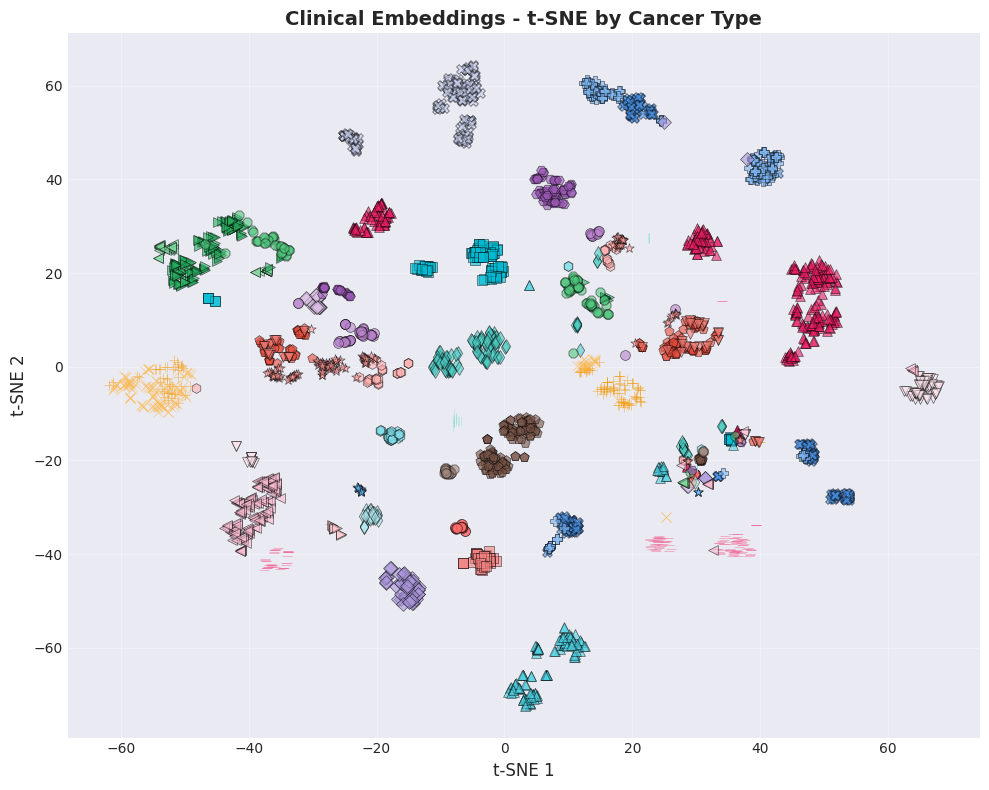

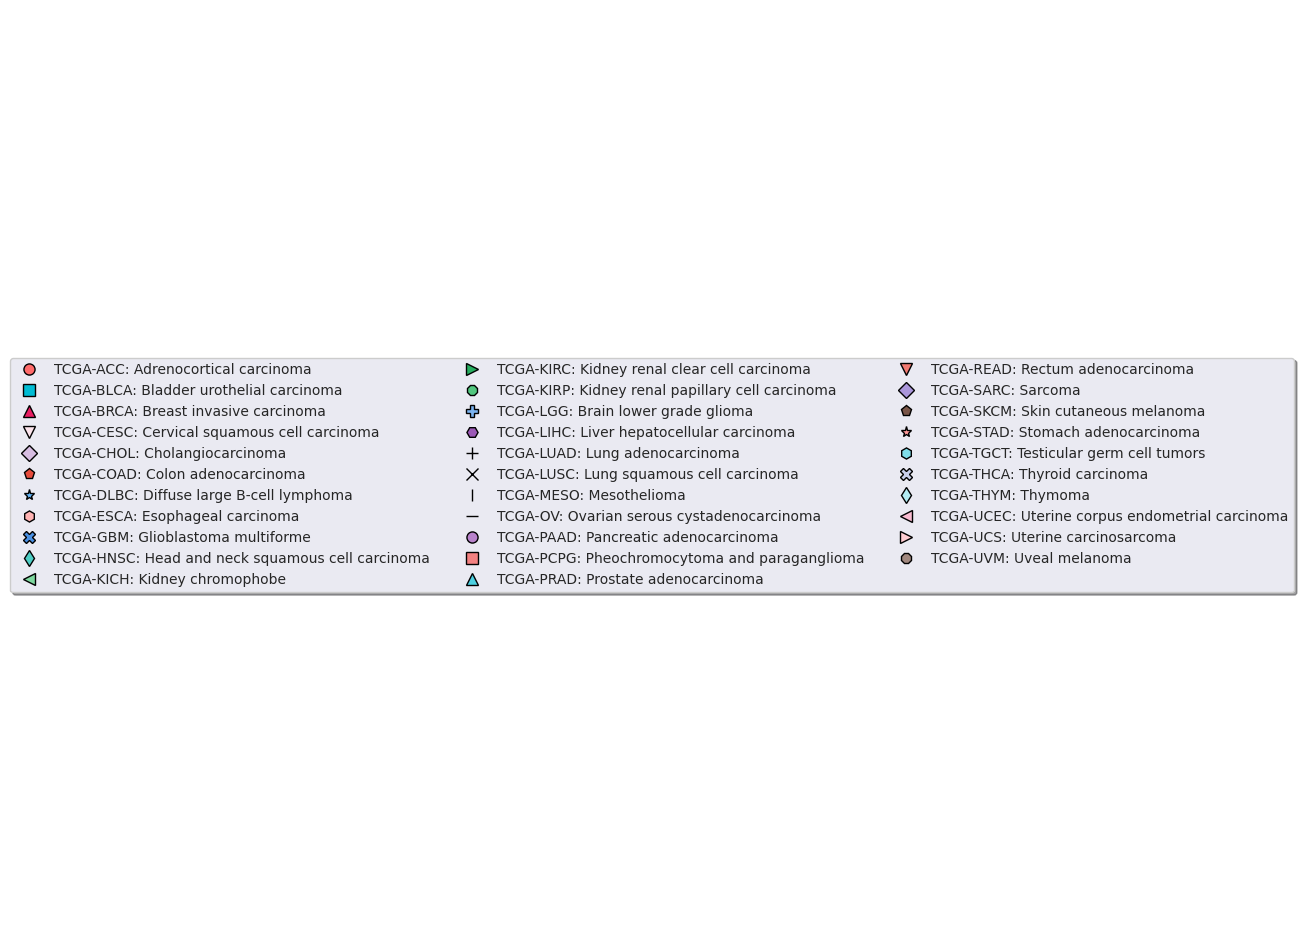

Computing t-SNE for 3000 samples...


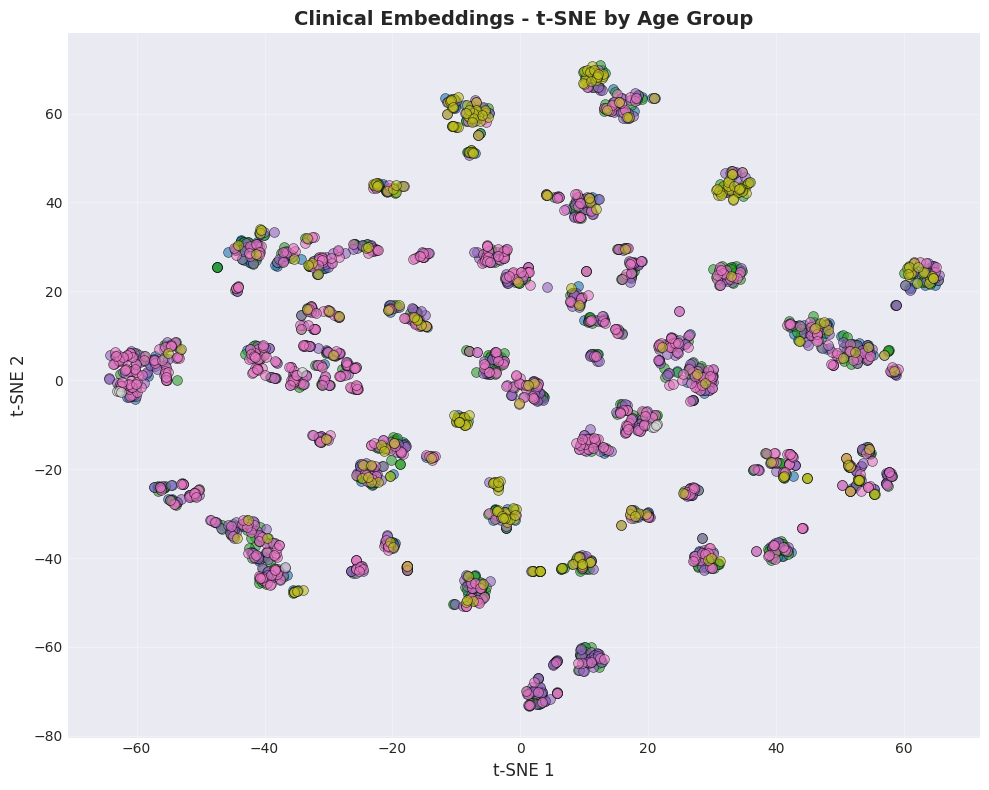

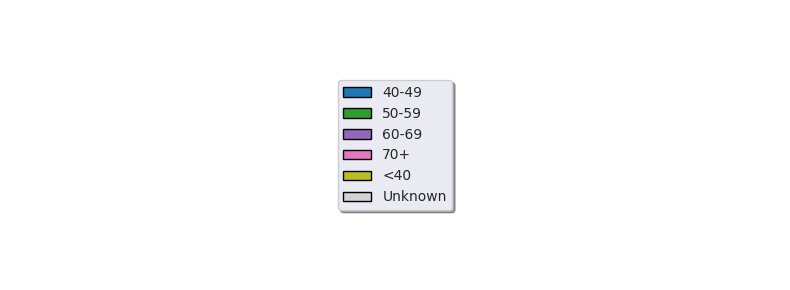

In [35]:
# Prepare clinical data for visualization
if clinical_embeddings is not None and clinical_metadata is not None:
    print(f"Clinical data: {len(clinical_metadata)} samples")
    print(f"Available columns: {list(clinical_metadata.columns)[:10]}...")  # Show first 10 columns
    
    # Add age groups if age data is available
    if 'age_at_index' in clinical_metadata.columns:
        clinical_metadata['age_group'] = clinical_metadata['age_at_index'].apply(create_age_groups)
    
    # Sample data for visualization (use 3000 samples for reasonable computation time)
    sample_size = min(3000, len(clinical_embeddings))
    
    # Visualize by cancer type (project_id)
    if 'project_id' in clinical_metadata.columns:
        labels = clinical_metadata['project_id'].values
        _ = create_tsne_visualization(
            clinical_embeddings, 
            labels,
            "Clinical Embeddings - t-SNE by Cancer Type",
            sample_size=sample_size
        )
    
    # Visualize by sex
    if 'sex' in clinical_metadata.columns:
        labels = clinical_metadata['sex'].fillna('Unknown').values
        _ = create_tsne_visualization(
            clinical_embeddings,
            labels,
            "Clinical Embeddings - t-SNE by Sex",
            sample_size=sample_size
        )
    
    # Visualize by age group
    if 'age_group' in clinical_metadata.columns:
        labels = clinical_metadata['age_group'].values
        _ = create_tsne_visualization(
            clinical_embeddings,
            labels,
            "Clinical Embeddings - t-SNE by Age Group",
            sample_size=sample_size
        )
else:
    print("Clinical embeddings not available")

### 5.2 Pathology Report Embeddings Visualization 🔬

Next, let's visualize pathology report embeddings. Since pathology metadata may be limited, we'll enrich it with patient information from our mapping to enable proper stratification:

🔬 PATHOLOGY EMBEDDINGS VISUALIZATION

📊 Pathology data statistics:
  Total samples: 10,857
  Embedding dimensions: 1024
  Available columns: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type']...

📌 Using 3,000 samples for visualization

🔄 Enriching pathology metadata with patient information...
  ✓ Successfully enriched 10,857 samples (100.0%)

🎨 Creating visualization by cancer type...
Computing t-SNE for 3000 samples...


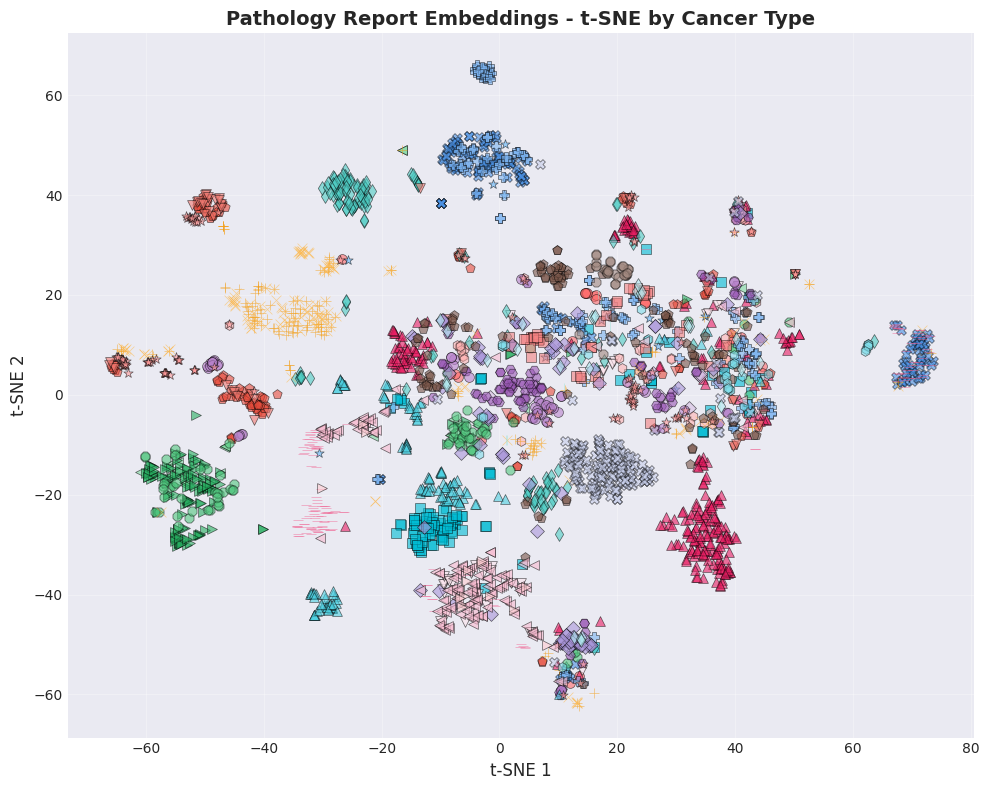

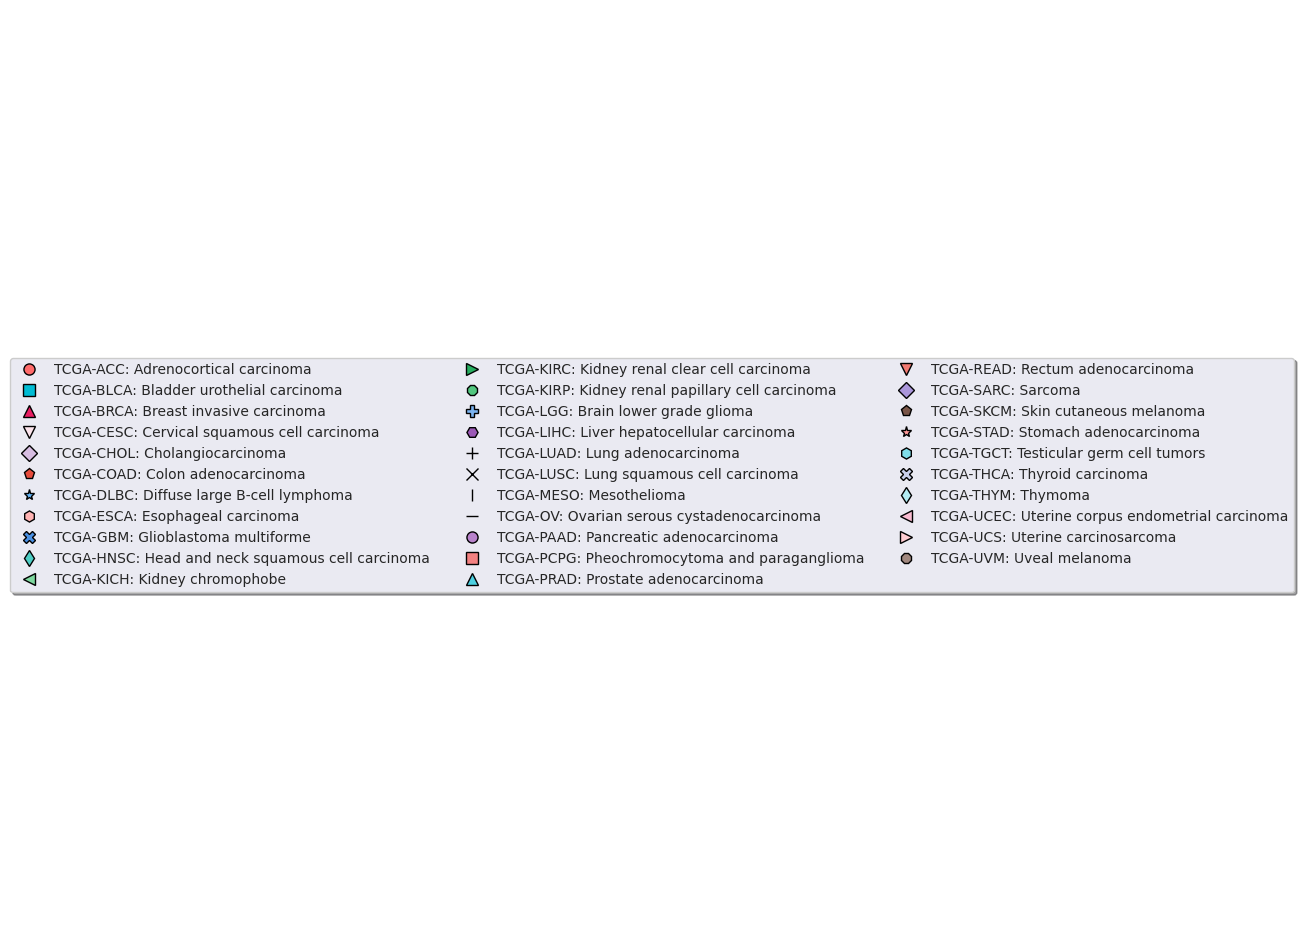


👥 Creating visualization by sex...
Computing t-SNE for 3000 samples...


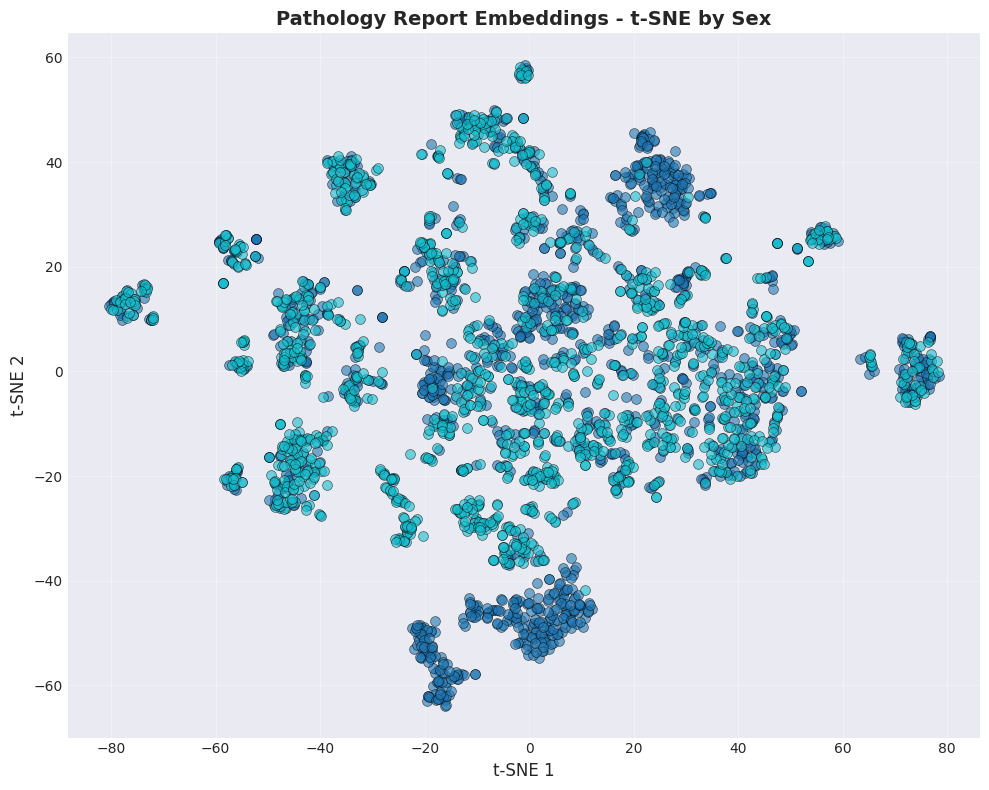

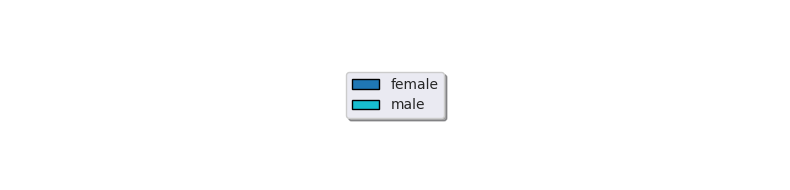


✅ Pathology visualization complete!


In [36]:
# Prepare pathology data for visualization
if pathology_embeddings is not None and pathology_metadata is not None:
    print("=" * 60)
    print("🔬 PATHOLOGY EMBEDDINGS VISUALIZATION")
    print("=" * 60)
    
    print(f"\n📊 Pathology data statistics:")
    print(f"  Total samples: {len(pathology_metadata):,}")
    print(f"  Embedding dimensions: {pathology_embeddings.shape[1]}")
    print(f"  Available columns: {list(pathology_metadata.columns)[:10]}...")
    
    # Sample data for visualization
    sample_size = min(3000, len(pathology_embeddings))
    print(f"\n📌 Using {sample_size:,} samples for visualization")
    
    # Try to enrich pathology metadata with clinical information
    print("\n🔄 Enriching pathology metadata with patient information...")
    enriched_pathology = []
    mapped_count = 0
    
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id and patient_id in patient_modality_map:
            # Get project_id from patient mapping
            project_id = patient_modality_map[patient_id].get('project_id', 'Unknown')
            gender = patient_modality_map[patient_id].get('gender', 'Unknown')
            age = patient_modality_map[patient_id].get('age_at_index', None)
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': project_id,
                'gender': gender,
                'age_at_index': age,
                'age_group': create_age_groups(age)
            })
            mapped_count += 1
        else:
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': 'Unknown',
                'gender': 'Unknown',
                'age_at_index': None,
                'age_group': 'Unknown'
            })
    
    enriched_pathology_df = pd.DataFrame(enriched_pathology)
    print(f"  ✓ Successfully enriched {mapped_count:,} samples ({(mapped_count/len(pathology_metadata))*100:.1f}%)")
    
    # Visualize by cancer type
    print("\n🎨 Creating visualization by cancer type...")
    labels = enriched_pathology_df['project_id'].values
    _ = create_tsne_visualization(
        pathology_embeddings,
        labels,
        "Pathology Report Embeddings - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by gender if we have enriched data
    if 'gender' in enriched_pathology_df.columns:
        print("\n👥 Creating visualization by sex...")
        labels = enriched_pathology_df['gender'].values
        _ = create_tsne_visualization(
            pathology_embeddings,
            labels,
            "Pathology Report Embeddings - t-SNE by Sex",
            sample_size=sample_size
        )
    
    print("\n✅ Pathology visualization complete!")
else:
    print("❌ Pathology embeddings not available")

## 6. Multimodal Integration and Visualization 🔗

Now we'll explore advanced strategies for integrating embeddings across modalities. Multimodal fusion is crucial for capturing the complete picture of cancer biology.

### Fusion Methods We'll Implement:

1. **Concatenation** 📎
   - Simply concatenate embeddings from different modalities
   - Preserves all information but results in high dimensions
   
2. **Mean Pooling** 📊
   - Average embeddings across modalities  
   - Creates unified representations with equal weighting
   
3. **Kronecker Product** ⊗
   - Captures pairwise interactions between modalities
   - Reveals synergistic patterns but computationally intensive

In [37]:
def create_multimodal_embeddings_batch(patient_list, patient_modality_map, embeddings_data, max_patients=3000):
    """
    Create multimodal embeddings efficiently using batch processing
    Following the approach from create_tsne_visualizations.py
    """
    # Sample if too many patients
    if len(patient_list) > max_patients:
        print(f"\nSampling {max_patients} patients for visualization...")
        np.random.seed(42)
        patient_list = np.random.choice(patient_list, max_patients, replace=False).tolist()
    
    print(f"\nCreating multimodal embeddings for {len(patient_list)} patients...")
    
    # Prepare embeddings data dictionary - filter out None values
    embeddings_dict = {k: v for k, v in embeddings_data.items() if v is not None}
    
    # Determine maximum dimensions for each fusion method
    max_concat_dim = sum(emb.shape[1] for emb in embeddings_dict.values() if emb is not None)
    max_mean_dim = max(emb.shape[1] for emb in embeddings_dict.values() if emb is not None)
    max_kron_dim = 100  # Limited for computational efficiency
    
    # Initialize result arrays
    n_patients = len(patient_list)
    concat_embeddings = []
    mean_embeddings = []
    kron_embeddings = []
    
    # Track valid embeddings and metadata
    valid_patients = []
    patient_metadata = []
    
    # Process patients
    for idx, patient_id in enumerate(patient_list):
        if idx % 500 == 0 and idx > 0:
            print(f"  Processing patient {idx}/{n_patients}...")
        
        patient_data = patient_modality_map.get(patient_id, {})
        
        # Get embeddings for this patient
        patient_embeddings = {}
        available_modalities = []
        
        for modality in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']:
            if modality in patient_data and modality in embeddings_dict:
                mod_idx = patient_data[modality]
                if embeddings_dict[modality] is not None and mod_idx < len(embeddings_dict[modality]):
                    emb = embeddings_dict[modality][mod_idx]
                    if not np.all(np.isnan(emb)):
                        patient_embeddings[modality] = emb
                        available_modalities.append(modality)
        
        # Skip if less than 2 modalities
        if len(patient_embeddings) < 2:
            continue
        
        # Store patient metadata
        patient_meta = {
            'patient_id': patient_id,
            'project_id': patient_data.get('project_id', 'Unknown'),
            'gender': patient_data.get('gender', 'Unknown'),
            'age_at_index': patient_data.get('age_at_index', None),
            'age_group': create_age_groups(patient_data.get('age_at_index', None)),
            'modality_combination': '+'.join(sorted(available_modalities))
        }
        patient_metadata.append(patient_meta)
        valid_patients.append(patient_id)
        
        # 1. Concatenation - concatenate all available embeddings
        concat_parts = []
        for mod_name in sorted(patient_embeddings.keys()):
            concat_parts.append(patient_embeddings[mod_name])
        concat_emb = np.concatenate(concat_parts)
        concat_embeddings.append(concat_emb)
        
        # 2. Mean pooling - average embeddings (with padding if needed)
        mean_parts = []
        for mod_name in sorted(patient_embeddings.keys()):
            emb = patient_embeddings[mod_name]
            if len(emb) < max_mean_dim:
                emb = np.pad(emb, (0, max_mean_dim - len(emb)), mode='constant')
            else:
                emb = emb[:max_mean_dim]
            mean_parts.append(emb)
        mean_emb = np.mean(mean_parts, axis=0)
        mean_embeddings.append(mean_emb)
        
        # 3. Kronecker product - limited to first 10 dimensions of first 2 modalities
        sorted_mods = sorted(patient_embeddings.keys())
        if len(sorted_mods) >= 2:
            emb1 = patient_embeddings[sorted_mods[0]][:10]
            emb2 = patient_embeddings[sorted_mods[1]][:10]
            kron = np.kron(emb1, emb2)
            if len(kron) > max_kron_dim:
                kron = kron[:max_kron_dim]
            elif len(kron) < max_kron_dim:
                kron = np.pad(kron, (0, max_kron_dim - len(kron)), mode='constant')
            kron_embeddings.append(kron)
        else:
            # Fallback - just use first modality repeated
            emb = patient_embeddings[sorted_mods[0]][:max_kron_dim]
            if len(emb) < max_kron_dim:
                emb = np.pad(emb, (0, max_kron_dim - len(emb)), mode='constant')
            kron_embeddings.append(emb)
    
    # Convert to numpy arrays
    if concat_embeddings:
        # Pad concatenated embeddings to same size
        max_concat_len = max(len(emb) for emb in concat_embeddings)
        padded_concat = []
        for emb in concat_embeddings:
            if len(emb) < max_concat_len:
                padded = np.pad(emb, (0, max_concat_len - len(emb)), mode='constant')
            else:
                padded = emb
            padded_concat.append(padded)
        concat_embeddings = np.array(padded_concat)
    else:
        concat_embeddings = None
        
    mean_embeddings = np.array(mean_embeddings) if mean_embeddings else None
    kron_embeddings = np.array(kron_embeddings) if kron_embeddings else None
    patient_metadata_df = pd.DataFrame(patient_metadata) if patient_metadata else None
    
    return {
        'concat': concat_embeddings,
        'mean_pool': mean_embeddings,
        'kronecker': kron_embeddings,
        'metadata': patient_metadata_df,
        'patient_list': valid_patients
    }

### 6.1 Prepare Multimodal Data 📋

First, let's identify patients with multiple modalities and prepare the data for fusion. This step ensures proper alignment across different data sources.

In [38]:
print("=" * 60)
print("🔗 MULTIMODAL DATA PREPARATION")
print("=" * 60)

# Get patients with 2+ modalities
print("\n🔍 Identifying patients with multiple modalities...")
multimodal_patients = []
modality_combo_counts = {}

for patient_id, patient_data in patient_modality_map.items():
    modalities = [k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']]
    if len(modalities) >= 2:
        multimodal_patients.append(patient_id)
        combo = '+'.join(sorted(modalities))
        modality_combo_counts[combo] = modality_combo_counts.get(combo, 0) + 1

print(f"\n✓ Total patients with 2+ modalities: {len(multimodal_patients):,}")

# Show top modality combinations
print("\n📊 Top 5 modality combinations:")
for combo, count in sorted(modality_combo_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    percentage = (count / len(multimodal_patients)) * 100
    print(f"  • {combo}: {count:,} patients ({percentage:.1f}%)")

# Create multimodal embeddings using the batch processing function
print("\n🔄 Creating multimodal embeddings...")
embeddings_data = {
    'clinical': clinical_embeddings,
    'pathology': pathology_embeddings,
    'wsi': wsi_embeddings,
    'molecular': molecular_embeddings,
    'radiology': radiology_embeddings
}

multimodal_results = create_multimodal_embeddings_batch(
    multimodal_patients, 
    patient_modality_map, 
    embeddings_data,
    max_patients=3000
)

print(f"\n✅ Multimodal embeddings successfully created:")
print(f"  📎 Concatenation: {multimodal_results['concat'].shape if multimodal_results['concat'] is not None else 'None'}")
print(f"  📊 Mean pooling: {multimodal_results['mean_pool'].shape if multimodal_results['mean_pool'] is not None else 'None'}")
print(f"  ⊗ Kronecker product: {multimodal_results['kronecker'].shape if multimodal_results['kronecker'] is not None else 'None'}")
print(f"  👥 Valid patients: {len(multimodal_results['patient_list']):,}")

🔗 MULTIMODAL DATA PREPARATION

🔍 Identifying patients with multiple modalities...

✓ Total patients with 2+ modalities: 10,790

📊 Top 5 modality combinations:
  • clinical+molecular+pathology+wsi: 6,937 patients (64.3%)
  • clinical+molecular+pathology: 2,702 patients (25.0%)
  • clinical+molecular+pathology+radiology+wsi: 949 patients (8.8%)
  • clinical+molecular+pathology+radiology: 155 patients (1.4%)
  • clinical+pathology+wsi: 19 patients (0.2%)

🔄 Creating multimodal embeddings...

Sampling 3000 patients for visualization...

Creating multimodal embeddings for 3000 patients...
  Processing patient 500/3000...
  Processing patient 1000/3000...
  Processing patient 1500/3000...
  Processing patient 2000/3000...
  Processing patient 2500/3000...

✅ Multimodal embeddings successfully created:
  📎 Concatenation: (3000, 4120)
  📊 Mean pooling: (3000, 1024)
  ⊗ Kronecker product: (3000, 100)
  👥 Valid patients: 3,000


### 6.2 Multimodal Fusion: Concatenation 📎

Concatenation is the simplest fusion method - we join embeddings end-to-end. This preserves all information from each modality.

📎 CONCATENATION FUSION ANALYSIS

📊 Concatenated embeddings statistics:
  Shape: (3000, 4120)
  Memory usage: 47.15 MB

🎨 Creating t-SNE visualization by cancer type...
Computing t-SNE for 3000 samples...


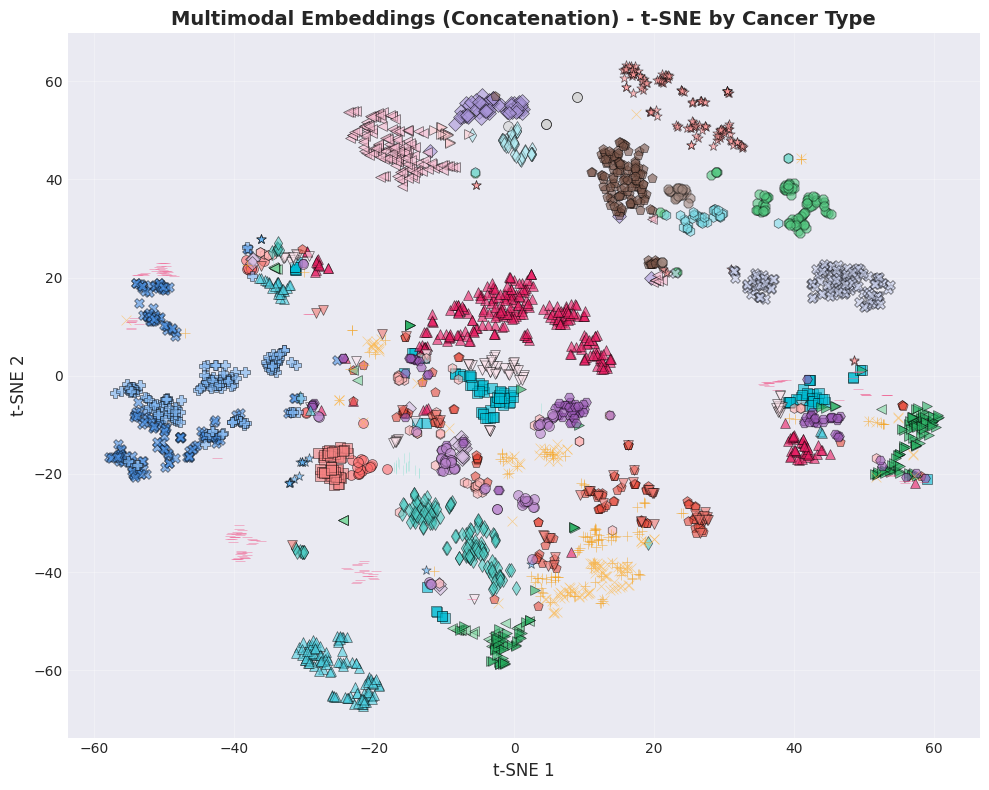

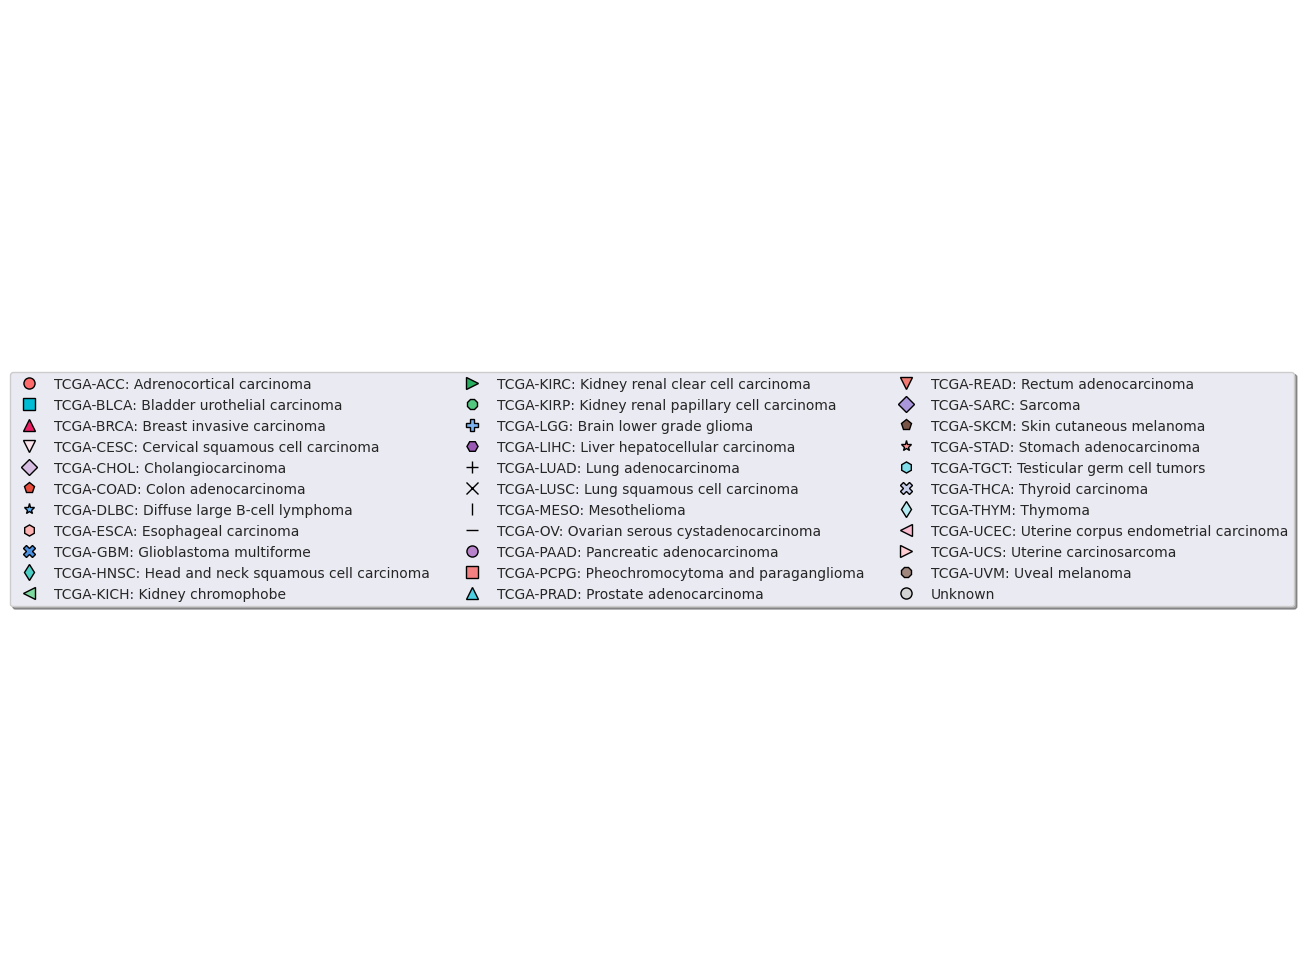


🔗 Creating t-SNE visualization by modality combination...
Computing t-SNE for 3000 samples...


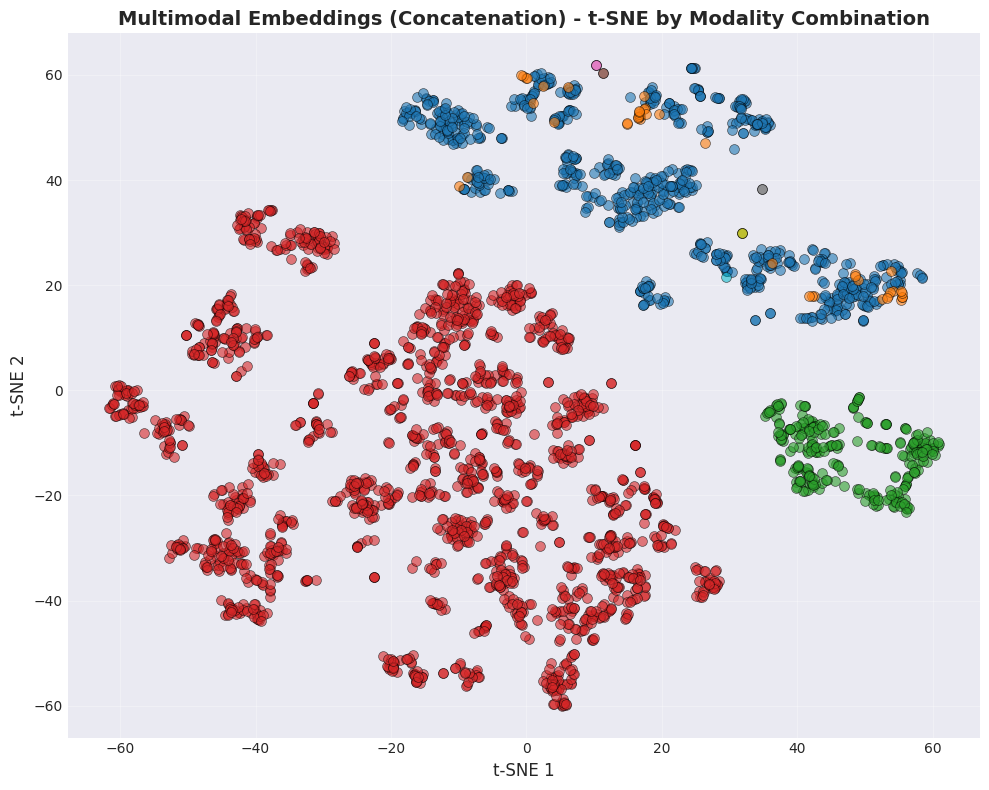

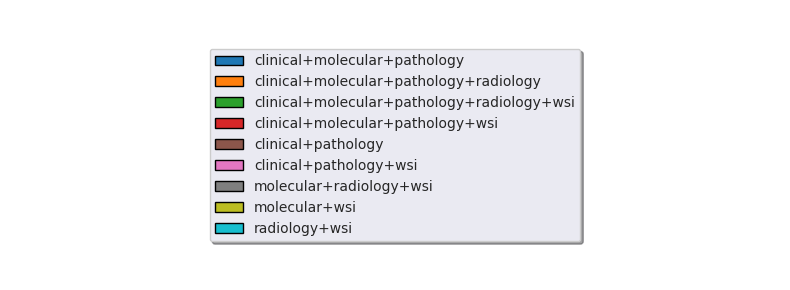


📈 Modality combination statistics:
--------------------------------------------------
                      modality_combination  count  percentage
          clinical+molecular+pathology+wsi   1882       62.73
              clinical+molecular+pathology    779       25.97
clinical+molecular+pathology+radiology+wsi    284        9.47
    clinical+molecular+pathology+radiology     44        1.47
                             molecular+wsi      3        0.10
                    clinical+pathology+wsi      3        0.10
                        clinical+pathology      2        0.07
                   molecular+radiology+wsi      2        0.07
                             radiology+wsi      1        0.03
--------------------------------------------------

✅ Concatenation fusion analysis complete!


In [39]:
if multimodal_results['concat'] is not None:
    print("=" * 60)
    print("📎 CONCATENATION FUSION ANALYSIS")
    print("=" * 60)
    
    # Concatenation fusion
    concat_embeddings = multimodal_results['concat']
    metadata = multimodal_results['metadata']
    
    print(f"\n📊 Concatenated embeddings statistics:")
    print(f"  Shape: {concat_embeddings.shape}")
    print(f"  Memory usage: {concat_embeddings.nbytes / (1024**2):.2f} MB")
    
    # Sample for visualization
    sample_size = min(3000, len(concat_embeddings))
    
    # Visualize by cancer type
    print("\n🎨 Creating t-SNE visualization by cancer type...")
    labels = metadata['project_id'].values
    _ = create_tsne_visualization(
        concat_embeddings,
        labels,
        "Multimodal Embeddings (Concatenation) - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by modality combination
    print("\n🔗 Creating t-SNE visualization by modality combination...")
    labels = metadata['modality_combination'].values
    _ = create_tsne_visualization(
        concat_embeddings,
        labels,
        "Multimodal Embeddings (Concatenation) - t-SNE by Modality Combination",
        sample_size=sample_size
    )
    
    # Save modality combination statistics
    combo_counts = metadata['modality_combination'].value_counts()
    combo_stats = pd.DataFrame({
        'modality_combination': combo_counts.index,
        'count': combo_counts.values,
        'percentage': (combo_counts.values / len(metadata) * 100).round(2)
    })
    
    print("\n📈 Modality combination statistics:")
    print("-" * 50)
    print(combo_stats.to_string(index=False))
    print("-" * 50)
    
    print("\n✅ Concatenation fusion analysis complete!")
else:
    print("❌ No multimodal concatenation embeddings available")

### 6.3 Multimodal Fusion: Mean Pooling 📊

Mean pooling creates a unified representation by averaging embeddings across modalities. This assumes equal importance for all modalities.

📊 MEAN POOLING FUSION ANALYSIS

📊 Mean pooled embeddings statistics:
  Shape: (3000, 1024)
  Memory usage: 11.72 MB
  Dimension reduction: 4.0x

🎨 Creating t-SNE visualization by cancer type...
Computing t-SNE for 3000 samples...


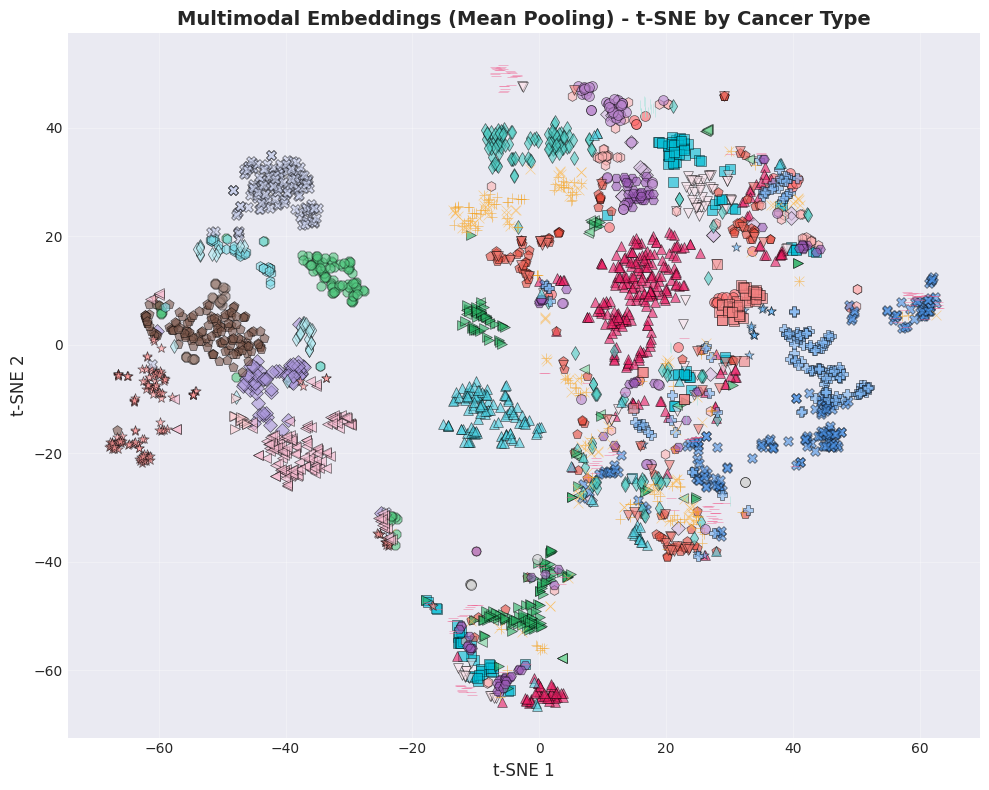

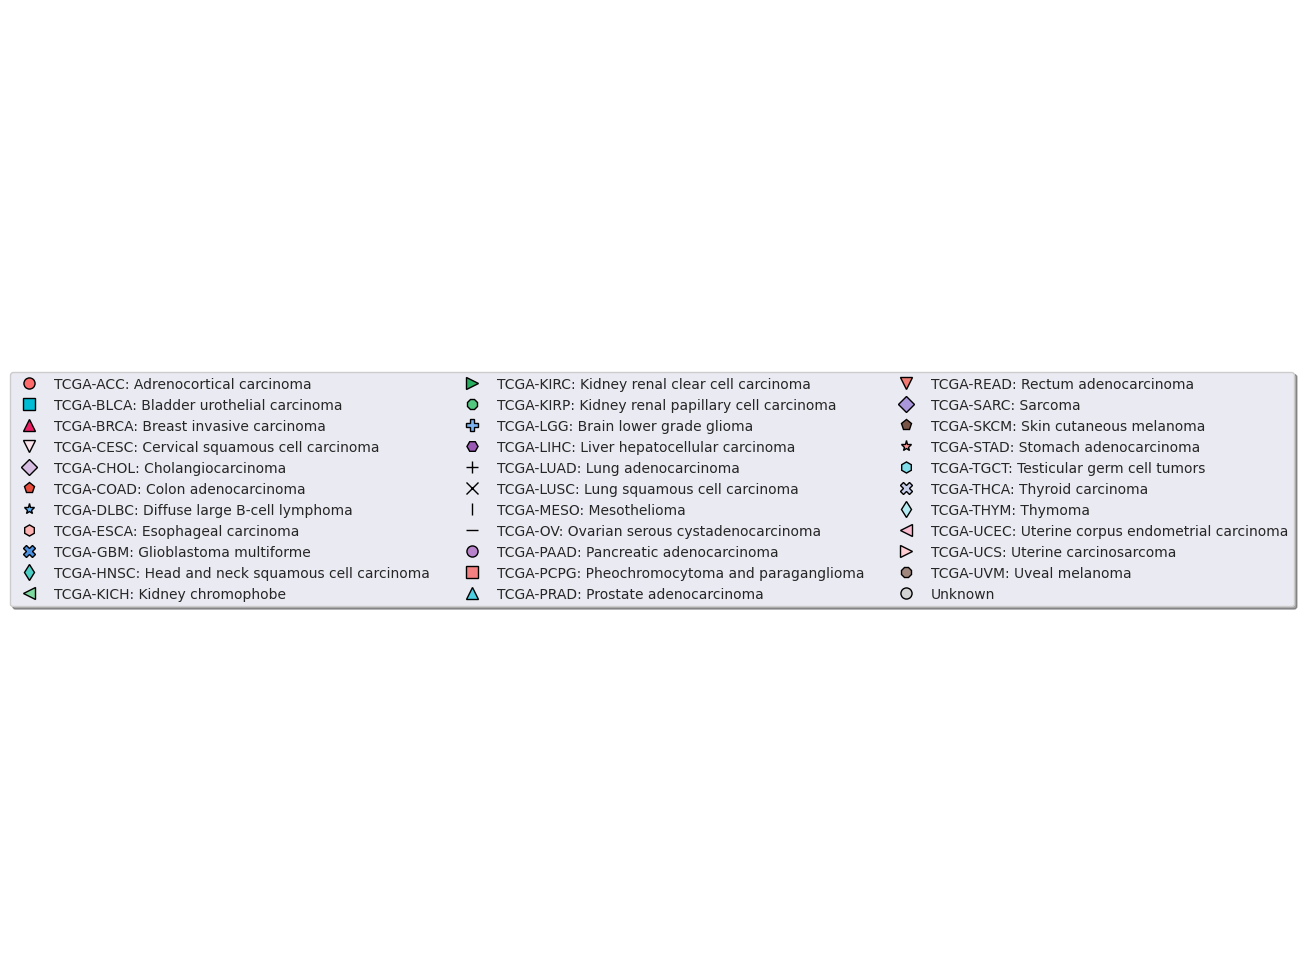


👥 Creating t-SNE visualization by sex...
Computing t-SNE for 3000 samples...


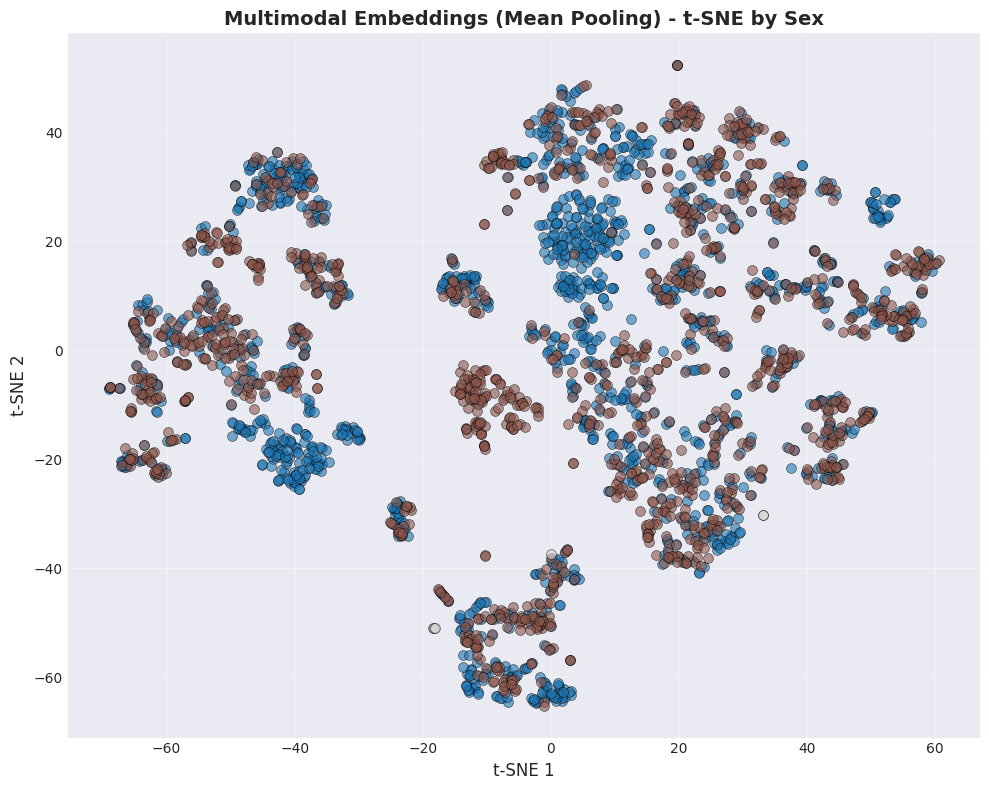

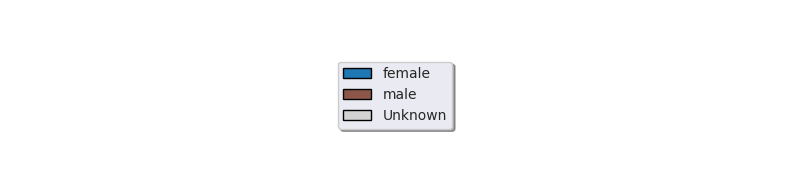


✅ Mean pooling fusion analysis complete!


In [40]:
if multimodal_results['mean_pool'] is not None:
    print("=" * 60)
    print("📊 MEAN POOLING FUSION ANALYSIS")
    print("=" * 60)
    
    # Mean pooling fusion
    mean_embeddings = multimodal_results['mean_pool']
    metadata = multimodal_results['metadata']
    
    print(f"\n📊 Mean pooled embeddings statistics:")
    print(f"  Shape: {mean_embeddings.shape}")
    print(f"  Memory usage: {mean_embeddings.nbytes / (1024**2):.2f} MB")
    print(f"  Dimension reduction: {concat_embeddings.shape[1] / mean_embeddings.shape[1]:.1f}x")
    
    # Visualize by cancer type
    print("\n🎨 Creating t-SNE visualization by cancer type...")
    labels = metadata['project_id'].values
    _ = create_tsne_visualization(
        mean_embeddings,
        labels,
        "Multimodal Embeddings (Mean Pooling) - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by sex
    print("\n👥 Creating t-SNE visualization by sex...")
    labels = metadata['gender'].values
    _ = create_tsne_visualization(
        mean_embeddings,
        labels,
        "Multimodal Embeddings (Mean Pooling) - t-SNE by Sex",
        sample_size=sample_size
    )
    
    print("\n✅ Mean pooling fusion analysis complete!")
else:
    print("❌ No multimodal mean pooling embeddings available")

### 6.4 Multimodal Fusion: Kronecker Product ⊗

The Kronecker product captures pairwise interactions between modalities, revealing synergistic patterns that simple concatenation might miss.

⊗ KRONECKER PRODUCT FUSION ANALYSIS

📊 Kronecker product embeddings statistics:
  Shape: (3000, 100)
  Memory usage: 1.14 MB
  Captures: Pairwise modality interactions

🎨 Creating t-SNE visualization by cancer type...
Computing t-SNE for 3000 samples...


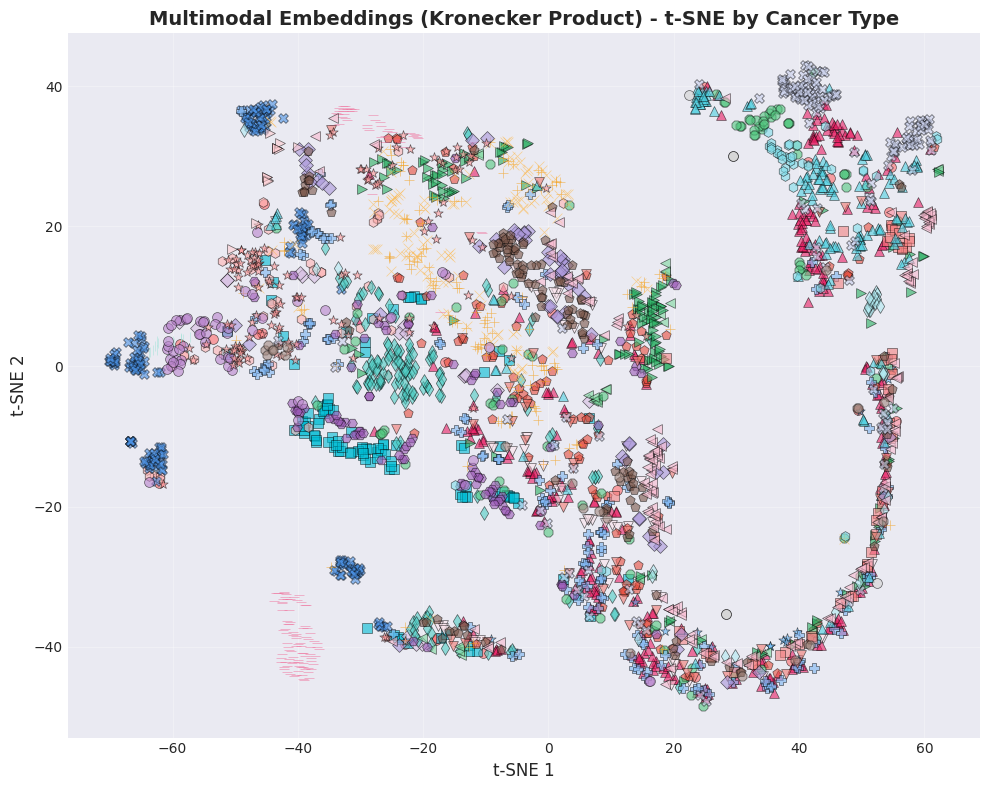

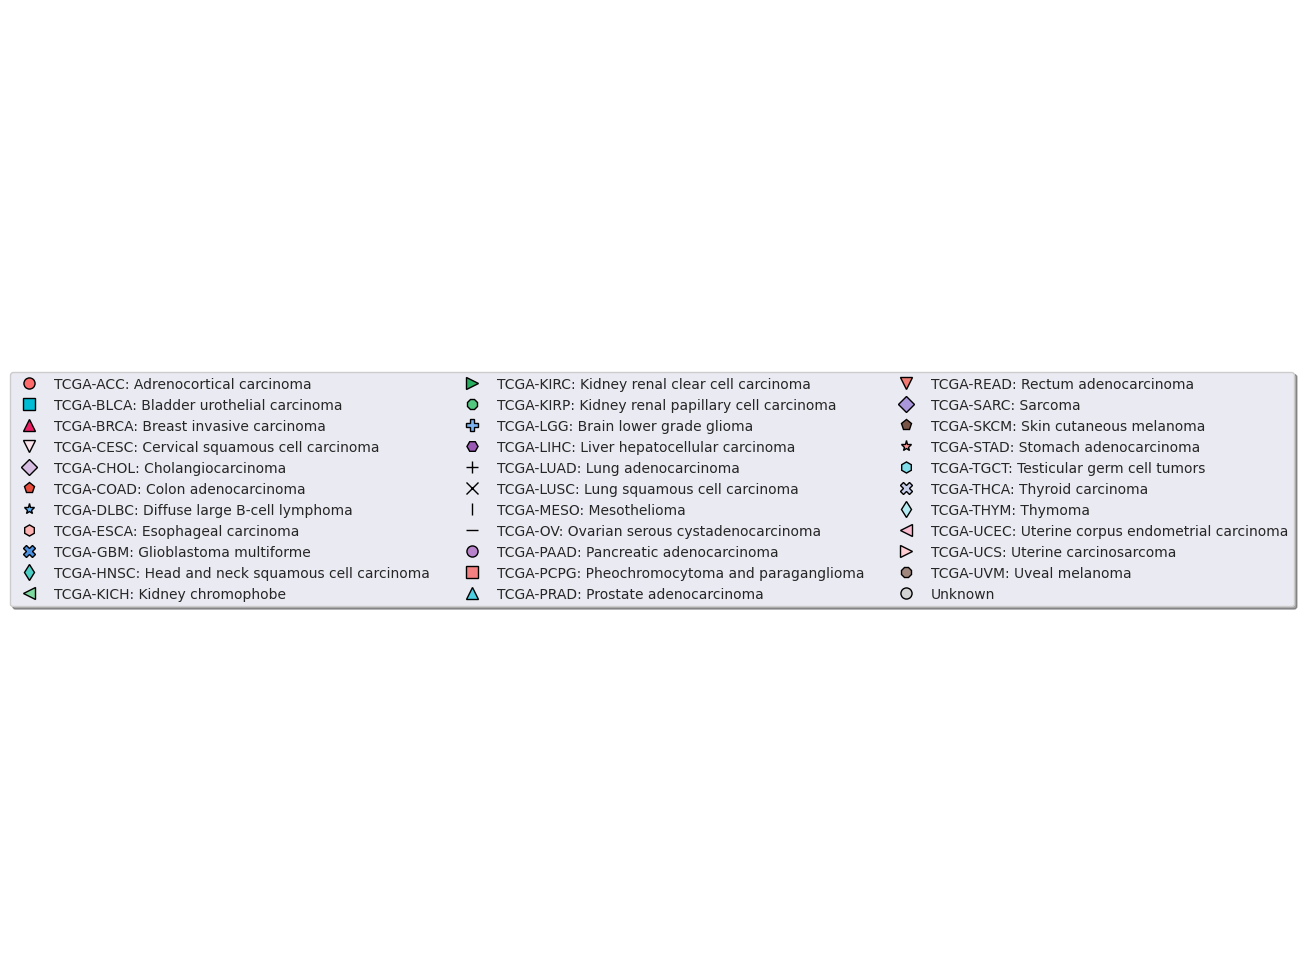


👥 Creating t-SNE visualization by age group...
Computing t-SNE for 3000 samples...


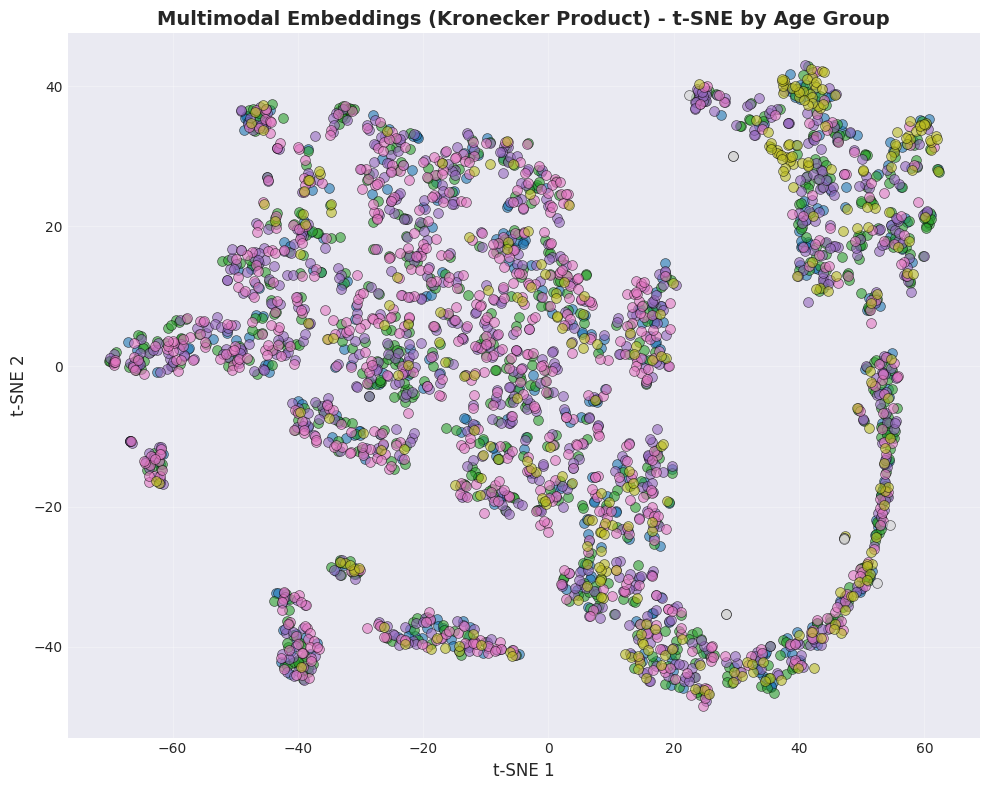

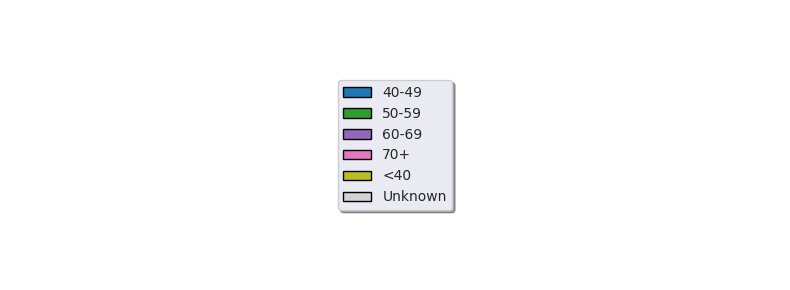


✅ Kronecker product fusion analysis complete!


In [41]:
if multimodal_results['kronecker'] is not None:
    print("=" * 60)
    print("⊗ KRONECKER PRODUCT FUSION ANALYSIS")
    print("=" * 60)
    
    # Kronecker product fusion
    kronecker_embeddings = multimodal_results['kronecker']
    metadata = multimodal_results['metadata']
    
    print(f"\n📊 Kronecker product embeddings statistics:")
    print(f"  Shape: {kronecker_embeddings.shape}")
    print(f"  Memory usage: {kronecker_embeddings.nbytes / (1024**2):.2f} MB")
    print(f"  Captures: Pairwise modality interactions")
    
    # Visualize by cancer type
    print("\n🎨 Creating t-SNE visualization by cancer type...")
    labels = metadata['project_id'].values
    _ = create_tsne_visualization(
        kronecker_embeddings,
        labels,
        "Multimodal Embeddings (Kronecker Product) - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by age group
    print("\n👥 Creating t-SNE visualization by age group...")
    labels = metadata['age_group'].values
    _ = create_tsne_visualization(
        kronecker_embeddings,
        labels,
        "Multimodal Embeddings (Kronecker Product) - t-SNE by Age Group",
        sample_size=sample_size
    )
    
    print("\n✅ Kronecker product fusion analysis complete!")
else:
    print("❌ No multimodal Kronecker embeddings available")

## 7. Analysis and Discussion 💡

### 7.1 Understanding Multimodal Integration

Let's analyze the characteristics and trade-offs of each fusion method:

#### **Concatenation** 📎
- ✅ **Advantages**: Preserves all information from each modality
- ❌ **Disadvantages**: High dimensionality, curse of dimensionality
- 🎯 **Best for**: When modalities contain complementary, non-redundant information

#### **Mean Pooling** 📊
- ✅ **Advantages**: Compact representation, computationally efficient
- ❌ **Disadvantages**: Assumes equal importance, may lose modality-specific signals
- 🎯 **Best for**: When all modalities are equally informative

#### **Kronecker Product** ⊗
- ✅ **Advantages**: Captures cross-modal interactions, reveals synergistic patterns
- ❌ **Disadvantages**: Computationally intensive, limited to pairwise interactions
- 🎯 **Best for**: Discovering relationships between modalities

### 7.2 Key Observations from t-SNE Visualizations 🔍

#### **1. Cancer Type Clustering** 🧬
- Similar cancer types cluster together (e.g., kidney cancers KIRC, KIRP, KICH)
- Organ system relationships are preserved in the embedding space
- TCGA color scheme helps visualize cancer type families

#### **2. Modality-Specific Insights** 🔬
- **Clinical**: Captures patient demographics and disease characteristics
- **Pathology**: Rich histological and diagnostic information
- **Molecular**: Genetic signatures and expression patterns
- **WSI**: Visual tissue architecture features
- **Radiology**: Anatomical and functional imaging characteristics

#### **3. Multimodal Benefits** 🚀
- Improved cluster separation between cancer types
- Reveals disease subtypes within cancer categories
- More comprehensive patient representations
- Better capture of disease heterogeneity

### 7.3 Clinical Implications 🏥

The multimodal approach enables:
1. **Precision Medicine**: More accurate patient stratification
2. **Biomarker Discovery**: Cross-modal pattern identification
3. **Treatment Planning**: Comprehensive patient profiling
4. **Prognosis**: Better outcome prediction with integrated data

## 8. Comparison with Different Embedding Models 🔄

Let's explore how different state-of-the-art embedding models affect representation quality. Each model brings unique strengths to the analysis.

🔄 EMBEDDING MODEL COMPARISON

📚 Loading alternative embedding models for clinical data...

🔄 Loading GATORTRON...

📊 Checking clinical_gatortron data structure:
  Keys available: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number']...
  Original embedding shape: [1024]
  Sample embedding shape: (1024,)
  ✓ Final clinical_gatortron embeddings shape: (10771, 1024)
  ✓ GATORTRON loaded - Shape: (10771, 1024)

🔄 Loading MEDGEMMA...

📊 Checking clinical_medgemma data structure:
  Keys available: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number']...
  Original embedding shape: [2560]
  Sample embedding shape: (2560,)
  ✓ Final clinical_medgemma embeddings shape: (10771, 2560)
  ✓ MEDGEMMA lo

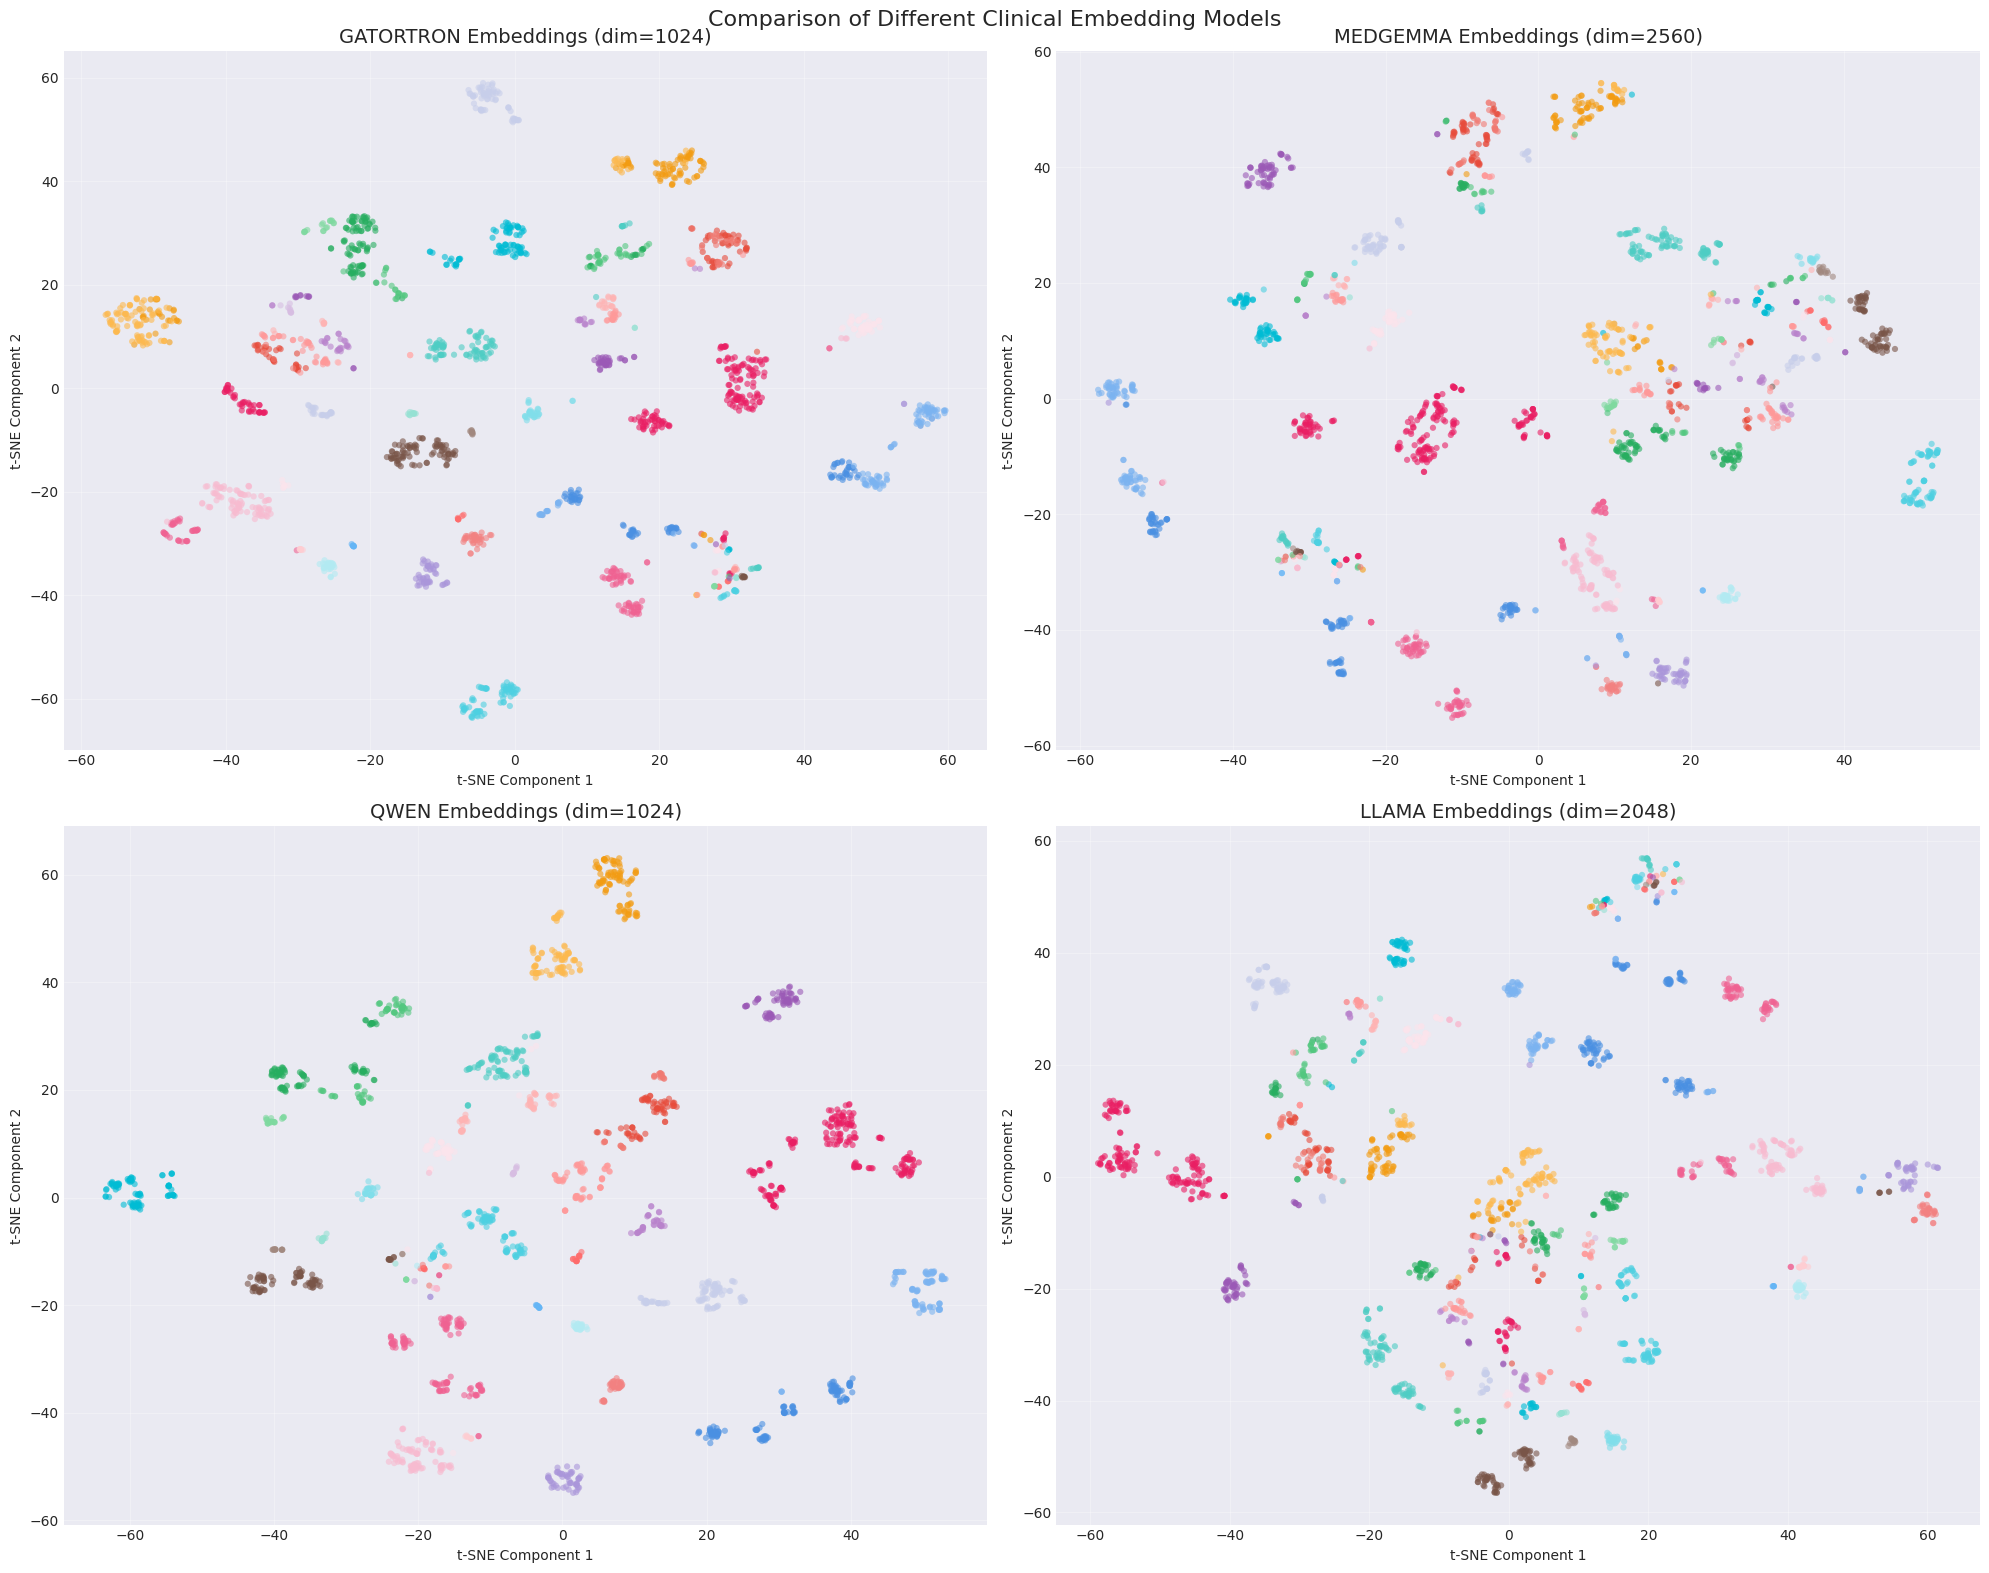


✅ Model comparison complete!

📊 Model Statistics:
------------------------------------------------------------
Model           Dimensions      Samples        
------------------------------------------------------------
GATORTRON       1024            10,771         
MEDGEMMA        2560            10,771         
QWEN            1024            10,771         
LLAMA           2048            10,771         
------------------------------------------------------------


In [42]:
# Load different embedding models for comparison
print("=" * 60)
print("🔄 EMBEDDING MODEL COMPARISON")
print("=" * 60)

print("\n📚 Loading alternative embedding models for clinical data...")

models_to_compare = ['gatortron', 'medgemma', 'qwen', 'llama']
clinical_embeddings_by_model = {}

for model in models_to_compare:
    try:
        print(f"\n🔄 Loading {model.upper()}...")
        dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split=model)
        embeddings, metadata = extract_embeddings_and_metadata(dataset, f'clinical_{model}')
        
        if embeddings is not None:
            clinical_embeddings_by_model[model] = {
                'embeddings': embeddings,
                'metadata': metadata
            }
            print(f"  ✓ {model.upper()} loaded - Shape: {embeddings.shape}")
    except Exception as e:
        print(f"  ❌ Could not load {model}: {e}")

# Create comparison visualization
if len(clinical_embeddings_by_model) > 1:
    print("\n🎨 Creating model comparison visualization...")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    for idx, (model_name, model_data) in enumerate(clinical_embeddings_by_model.items()):
        if idx < 4:
            ax = axes[idx]
            
            # Get embeddings and metadata
            embeddings = model_data['embeddings']
            metadata = model_data['metadata']
            
            # Add age groups
            if 'age_at_index' in metadata.columns:
                metadata['age_group'] = metadata['age_at_index'].apply(create_age_groups)
            
            # Sample for visualization
            sample_size = min(2000, len(embeddings))
            indices = np.random.choice(len(embeddings), sample_size, replace=False)
            sampled_embeddings = embeddings[indices]
            sampled_labels = metadata.iloc[indices]['project_id'].values if 'project_id' in metadata.columns else ['Unknown'] * sample_size
            
            # Apply t-SNE
            print(f"\n  📊 Computing t-SNE for {model_name.upper()}...")
            scaler = StandardScaler()
            embeddings_scaled = scaler.fit_transform(sampled_embeddings)
            
            if embeddings_scaled.shape[1] > 50:
                pca = PCA(n_components=50)
                embeddings_scaled = pca.fit_transform(embeddings_scaled)
            
            tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
            embeddings_2d = tsne.fit_transform(embeddings_scaled)
            
            # Plot
            tcga_colors = get_tcga_color_scheme()
            unique_labels = np.unique(sampled_labels)
            
            for label in unique_labels:
                mask = sampled_labels == label
                ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                          c=[tcga_colors.get(label, '#BDBDBD')],
                          label=label, s=20, alpha=0.6, edgecolors='none')
            
            ax.set_title(f'{model_name.upper()} Embeddings (dim={embeddings.shape[1]})', fontsize=14)
            ax.set_xlabel('t-SNE Component 1')
            ax.set_ylabel('t-SNE Component 2')
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comparison of Different Clinical Embedding Models', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Model comparison complete!")
    
    # Print model statistics
    print("\n📊 Model Statistics:")
    print("-" * 60)
    print(f"{'Model':<15} {'Dimensions':<15} {'Samples':<15}")
    print("-" * 60)
    for model_name, model_data in clinical_embeddings_by_model.items():
        dims = model_data['embeddings'].shape[1]
        samples = model_data['embeddings'].shape[0]
        print(f"{model_name.upper():<15} {dims:<15} {samples:<15,}")
    print("-" * 60)
else:
    print("\n⚠️ Not enough models loaded for comparison")